## insert the dataset name and the number of epochs under the main function.
## make sure the paths are correct, also under main.

In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def load_image(image_path):
    """Load image using PIL and convert to numpy array."""
    image = Image.open(image_path)
    image_array = np.array(image)
    return image_array

def calculate_similarity_metrics(image1, image2):
    """Calculate similarity metrics between two images."""
    # Convert images to numpy arrays if they are not already
    image1 = np.array(image1)
    image2 = np.array(image2)
    
    # Ensure images are of the same shape
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions.")
    
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(image1.flatten(), image2.flatten(), labels=[0, 1])
    tn, fp, fn, tp = confusion_mat.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(image1.flatten(), image2.flatten())
    precision = precision_score(image1.flatten(), image2.flatten())
    recall = recall_score(image1.flatten(), image2.flatten())
    f1 = f1_score(image1.flatten(), image2.flatten())
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    similarity_percentage = (tp + tn) / image1.size * 100  # Overall similarity percentage
    
    # Return metrics and confusion matrix values
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'similarity_percentage': similarity_percentage,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def compare_images_in_folders(folder1, folder2):
    """Compare images in two folders and calculate metrics."""
    # Get list of TIF files in each folder
    tif_files1 = sorted([f for f in os.listdir(folder1) if f.lower().endswith('.tif')])
    tif_files2 = sorted([f for f in os.listdir(folder2) if f.lower().endswith('.tif')])
    
    # Check if number of TIFF files match
    if len(tif_files1) != len(tif_files2):
        raise ValueError("Number of TIFF files in the two folders do not match.")
    
    results = []
    
    # Iterate through TIFF files and compare corresponding images
    for file1, file2 in zip(tif_files1, tif_files2):
        if file1 != file2:
            raise ValueError("Files in the two folders do not match.")
        
        # Construct full file paths for TIFF files
        image_path1 = os.path.join(folder1, file1)
        image_path2 = os.path.join(folder2, file2)
        
        # Load images
        image1 = load_image(image_path1)
        image2 = load_image(image_path2)
        
        # Calculate similarity metrics including confusion matrix
        metrics = calculate_similarity_metrics(image1, image2)
        metrics['file'] = file1
        metrics['image1_path'] = image_path1
        metrics['image2_path'] = image_path2
        
        # Add results to list
        results.append(metrics)
    
    return results

def display_results(results):
    """Display comparison results including metrics table, confusion matrices, and image comparison."""
    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    
    # Display metrics table
    print("Comparison Metrics:")
    print(df[['file', 'accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'similarity_percentage']].to_string(index=False))
    print("\n")
    
    # Determine the grid size for the plots
    num_images = len(results)
    num_cols = 3  # Three columns: Ground Truth, Predicted, and Confusion Matrix
    num_rows = num_images
    
    # Create a figure for all subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    for idx, result in enumerate(results):
        file_name = result['file']
        tp, tn, fp, fn = result['tp'], result['tn'], result['fp'], result['fn']
        
        # Display ground truth image
        image1 = load_image(result['image1_path'])
        axes[idx, 0].imshow(image1, cmap='gray')
        axes[idx, 0].set_title(f'Ground Truth: {file_name}')
        axes[idx, 0].axis('off')
        
        # Display predicted image
        image2 = load_image(result['image2_path'])
        axes[idx, 1].imshow(image2, cmap='gray')
        axes[idx, 1].set_title(f'Predicted: {file_name}')
        axes[idx, 1].axis('off')
        
        # Plot confusion matrix
        sns.heatmap([[tn, fp], [fn, tp]], annot=True, cmap='Blues', fmt='g', ax=axes[idx, 2])
        axes[idx, 2].set_xlabel('Predicted labels')
        axes[idx, 2].set_ylabel('True labels')
        axes[idx, 2].set_title(f'Confusion Matrix for {file_name}')
    
    plt.tight_layout()
    plt.show()

def save_metrics_to_csv(metrics_dict):
    """Save metrics dictionary to a CSV file."""
    df = pd.DataFrame(metrics_dict['metrics'])
    df['dataset'] = metrics_dict['dataset']
    df['epochs'] = metrics_dict['epochs']
    
    # Specify a custom directory if needed
    output_dir = '/argusdata/users/undergrads/ItamarAndDafna/metrics_2d/'  # Replace with your desired directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Construct the filename
    filename = f"metrics_{metrics_dict['dataset']}_{metrics_dict['epochs']}epochs.csv"
    file_path = os.path.join(output_dir, filename)
    df.to_csv(file_path, index=False)
    print(f"Metrics saved to {file_path}")

def main():
    # Define the dataset name manually here
    dataset_name = 'Dataset030_1030GlyRM1'
    
    # Ask user for number of epochs
    num_epochs = input("Enter the number of epochs: ")
    
    gt_folder = r'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_raw/Dataset030_1030GlyRM1/labelsTs/'
    results_folder = f'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_results/{dataset_name}/{num_epochs}ep/'

    # Compare images in the specified folders
    results = compare_images_in_folders(gt_folder, results_folder)
    
    # Display results
    display_results(results)
    
    # Store metrics in a dictionary
    metrics_dict = {
        'dataset': dataset_name,
        'epochs': num_epochs,
        'metrics': results
    }
    
    # Save metrics to a CSV file
    save_metrics_to_csv(metrics_dict)
    
    return metrics_dict

# Run the main function
metrics_dict = main()

# Print the stored metrics dictionary
print(metrics_dict)


FileNotFoundError: [Errno 2] No such file or directory: '/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_results/Dataset030_1030GlyRM1/ep/'

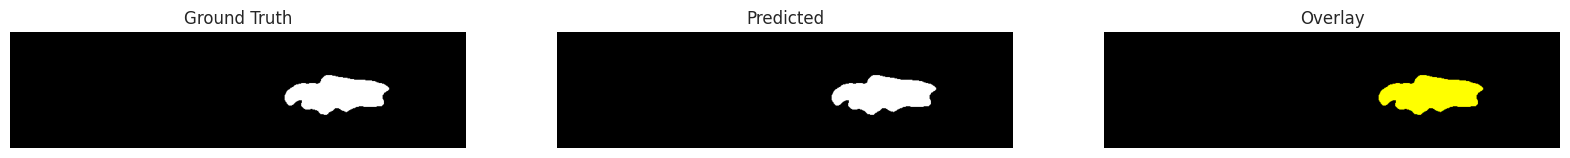

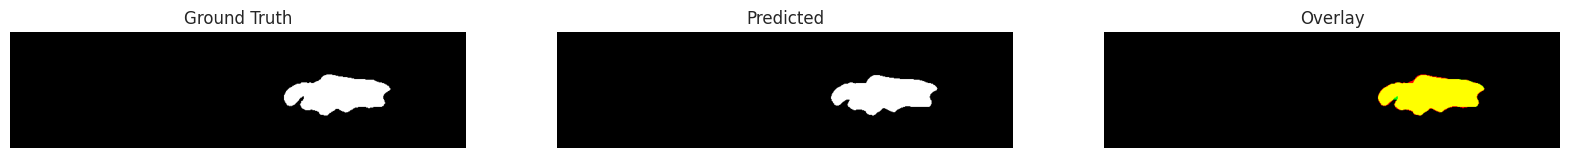

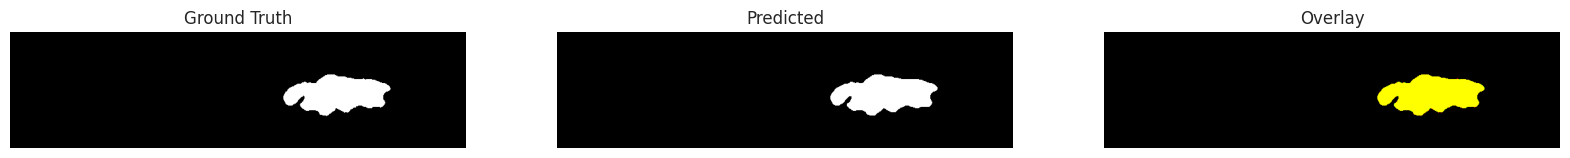

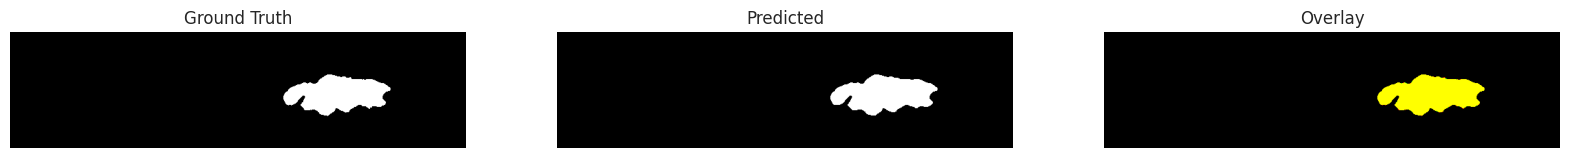

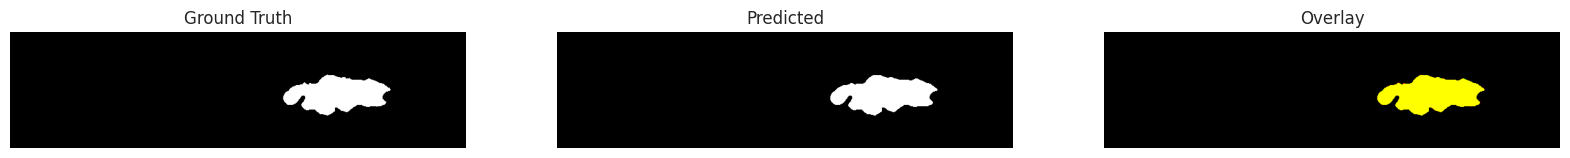

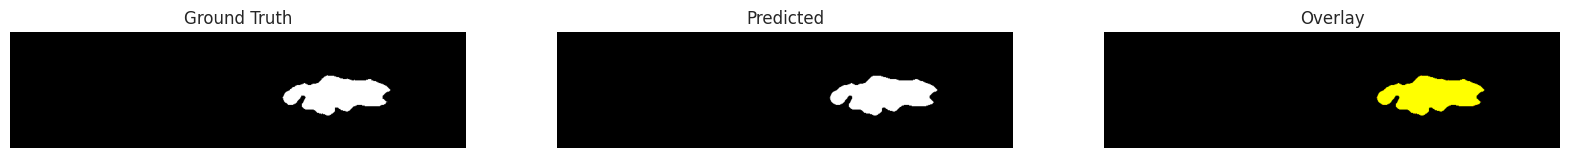

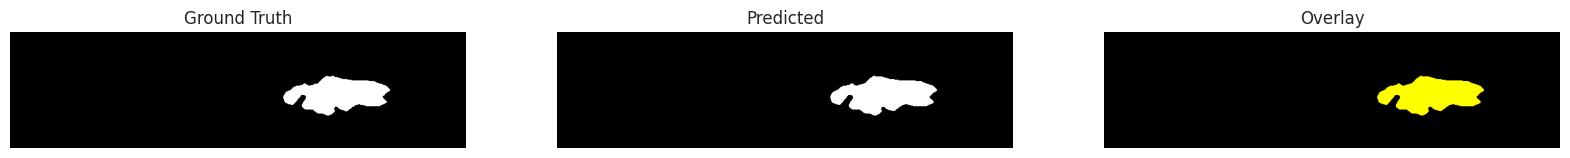

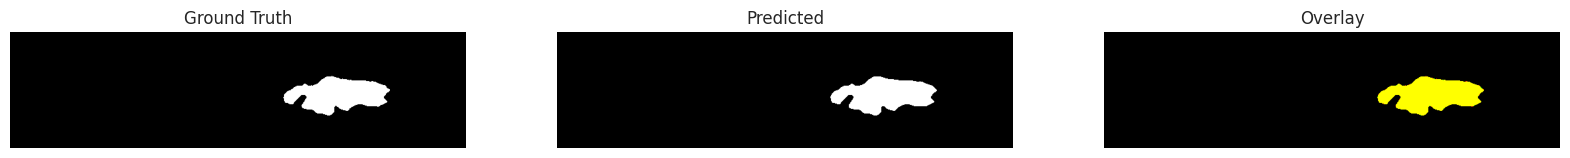

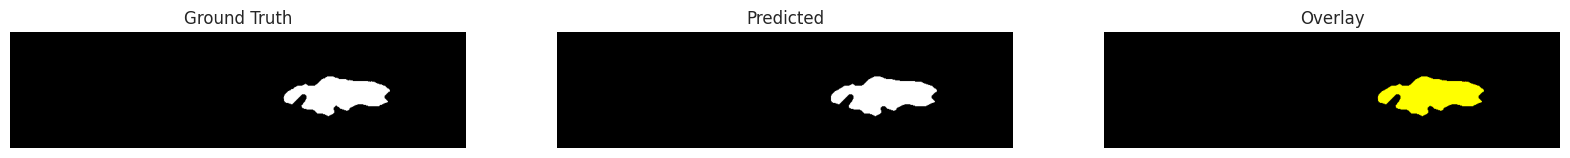

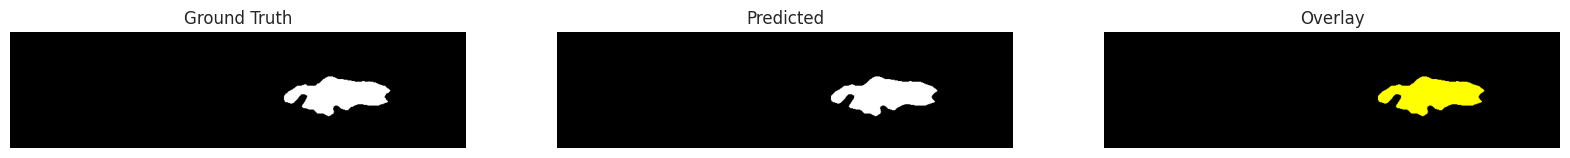

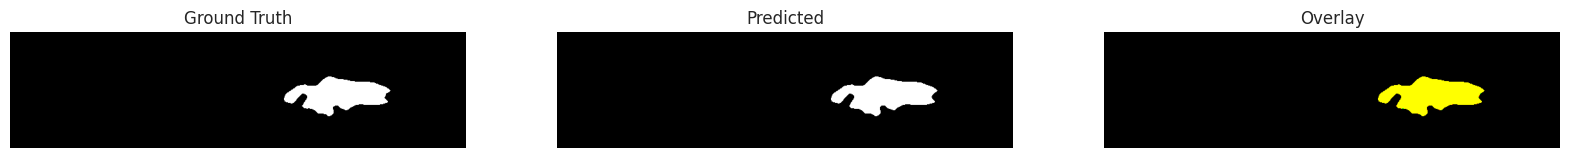

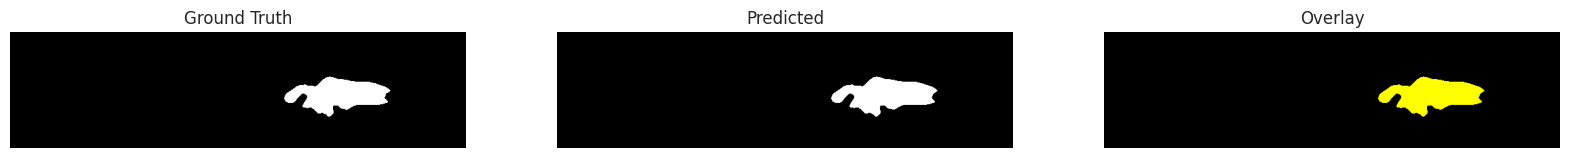

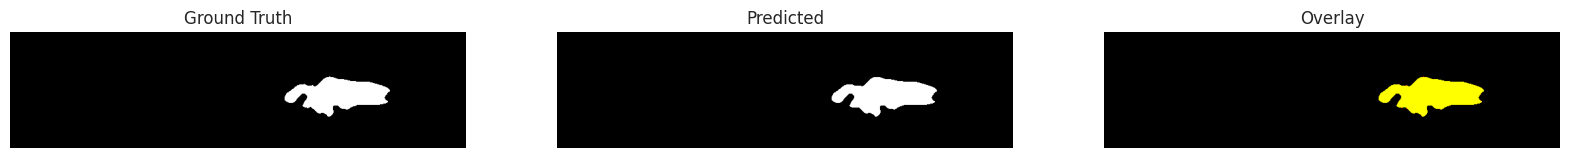

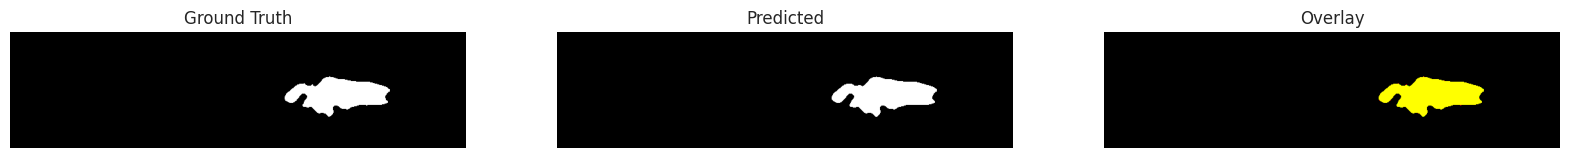

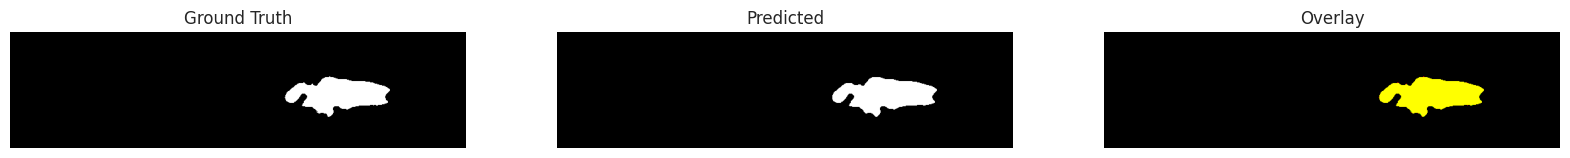

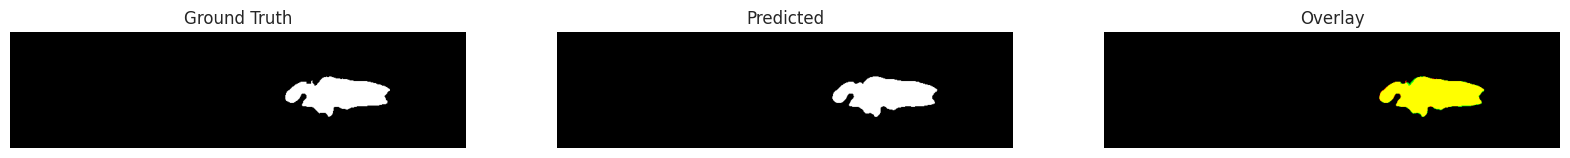

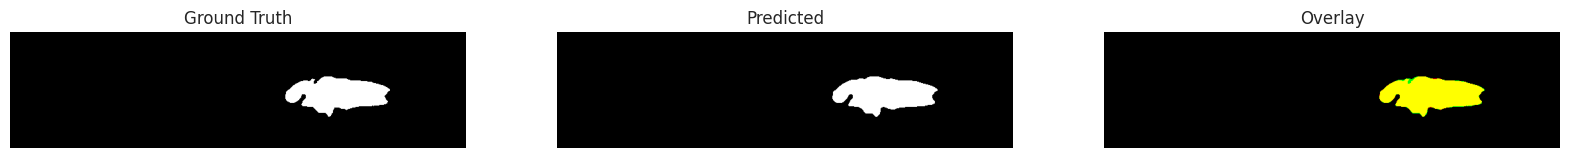

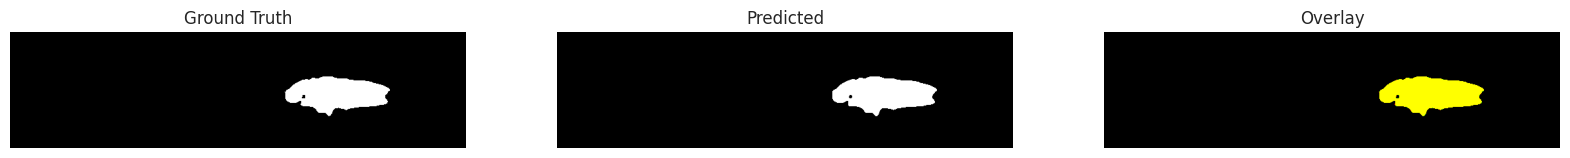

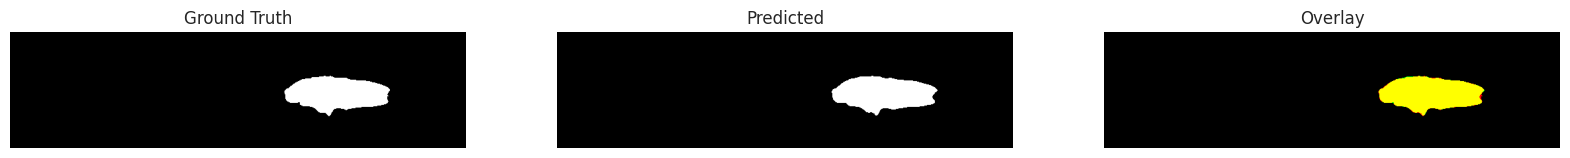

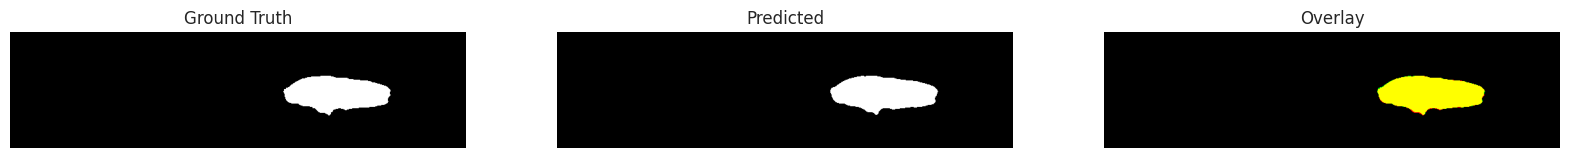

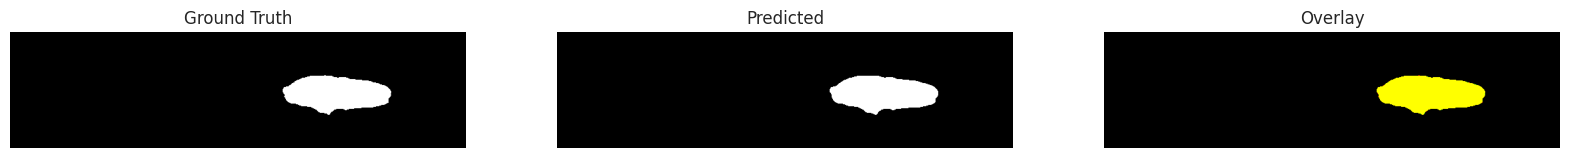

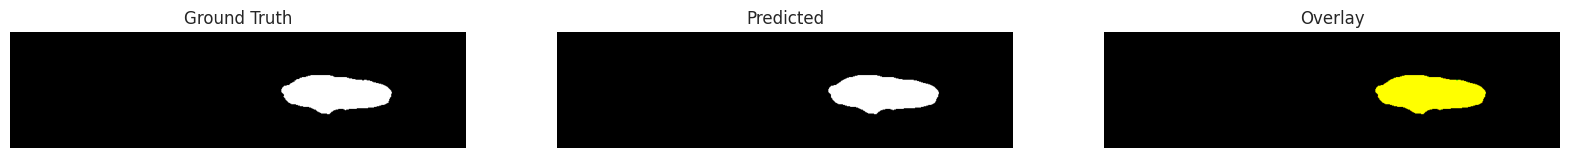

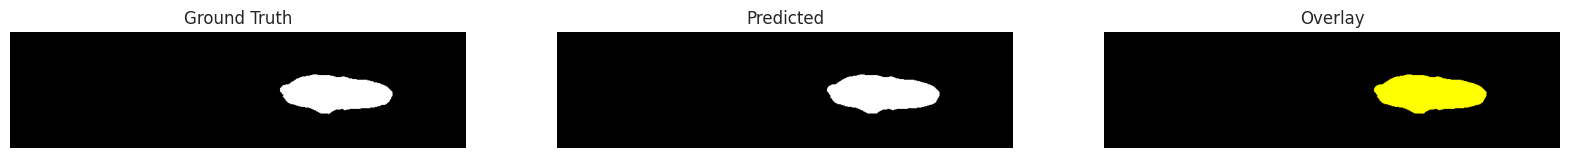

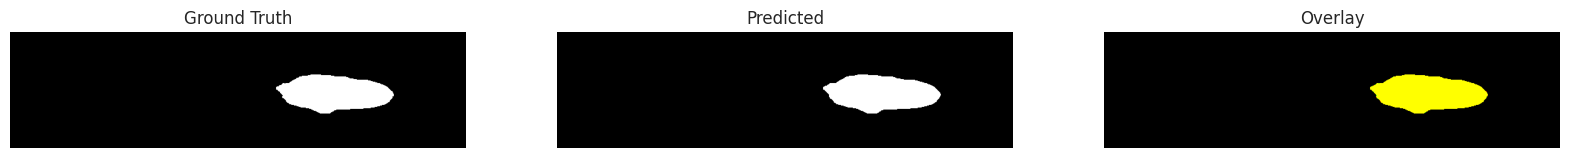

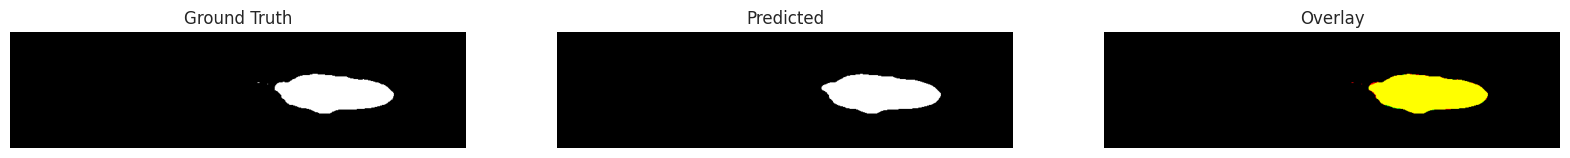

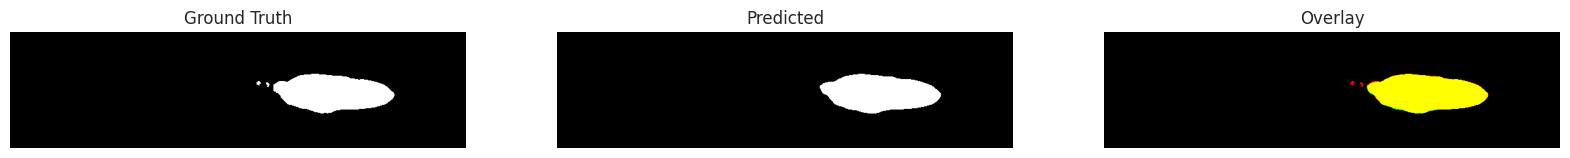

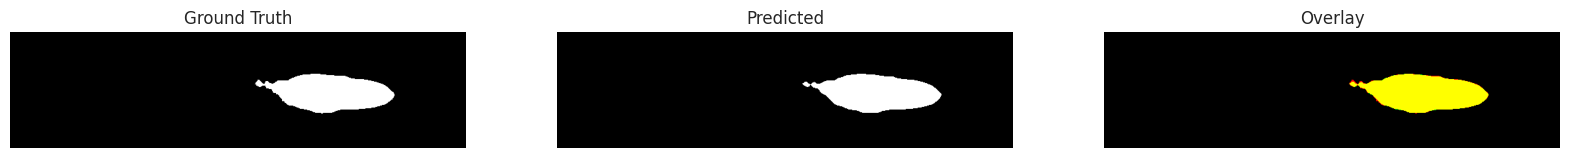

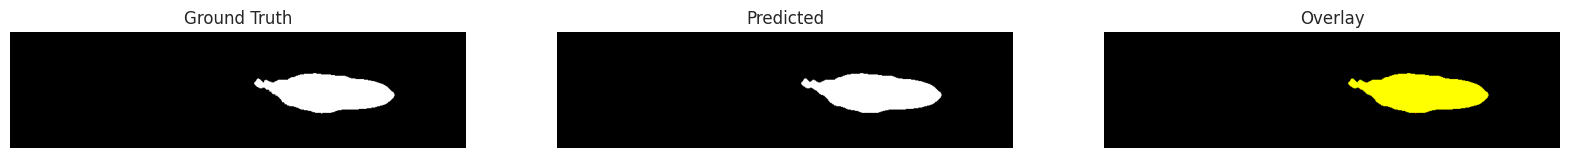

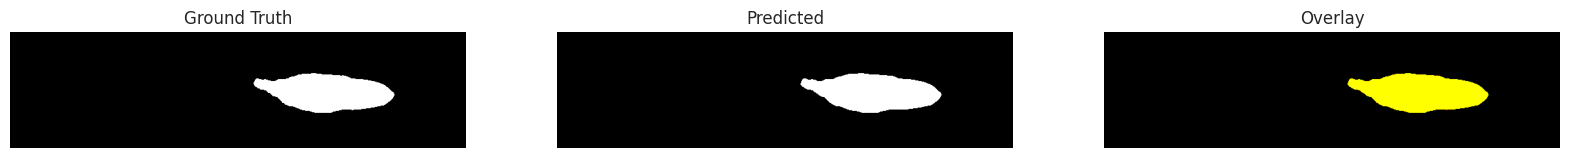

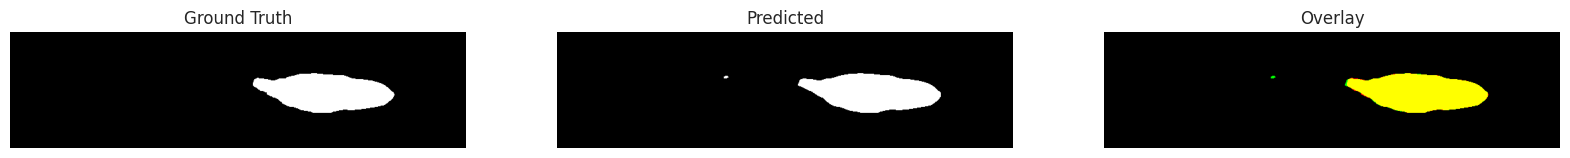

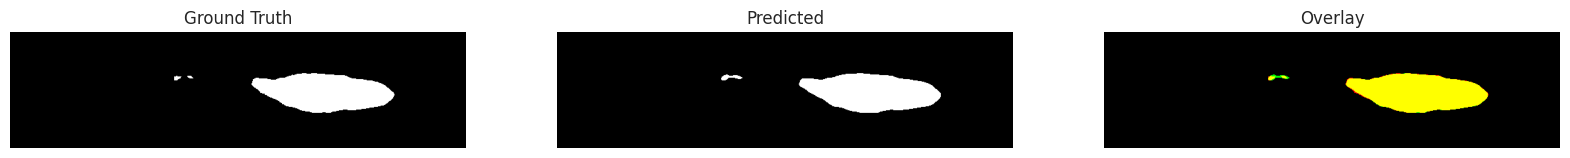

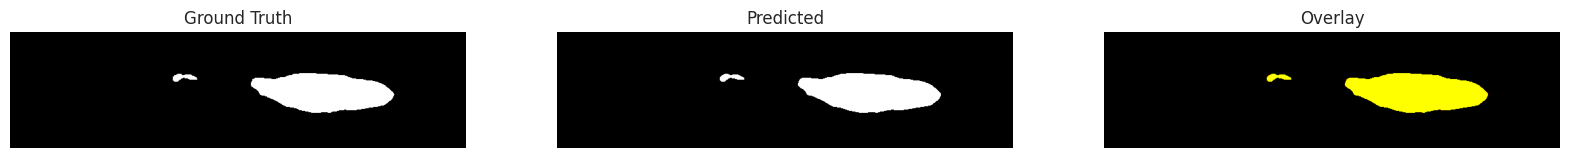

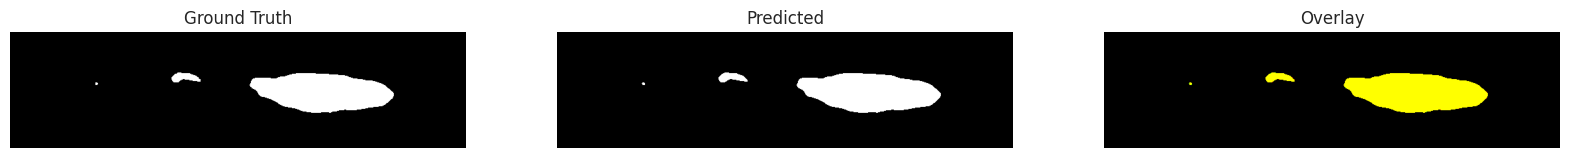

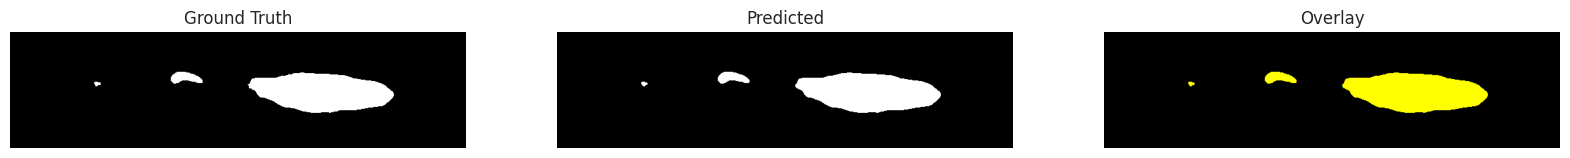

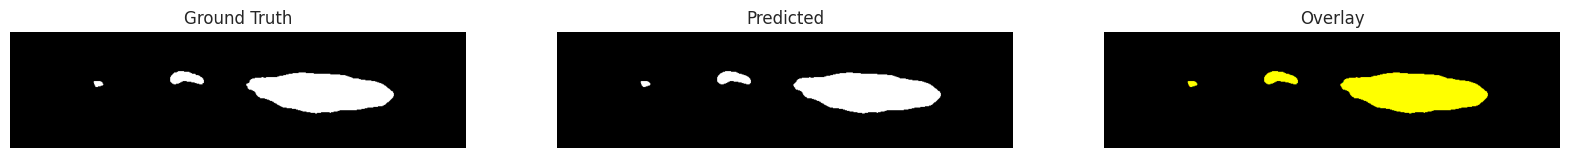

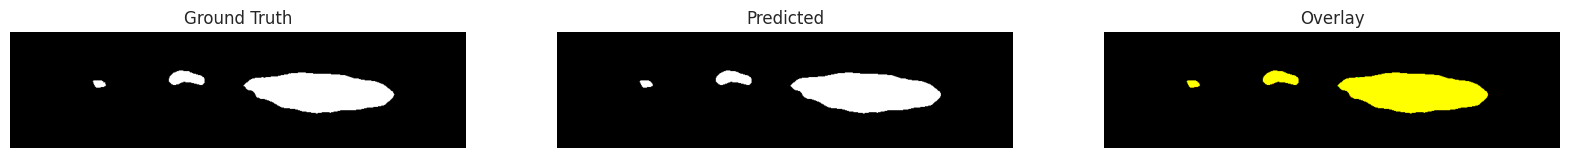

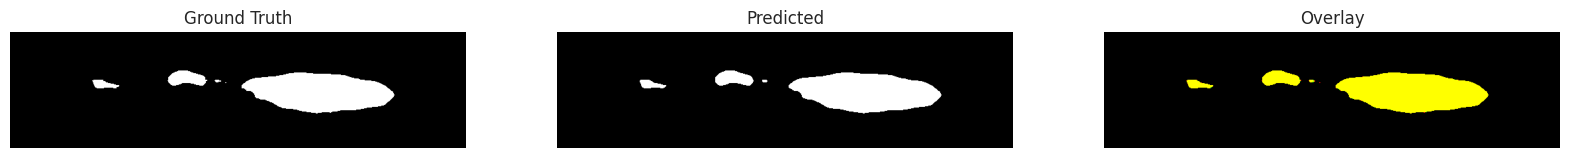

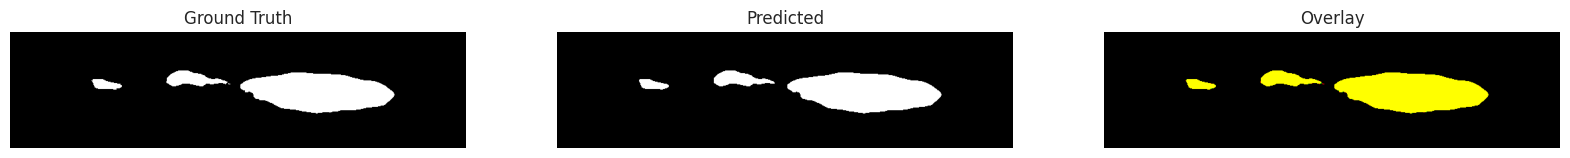

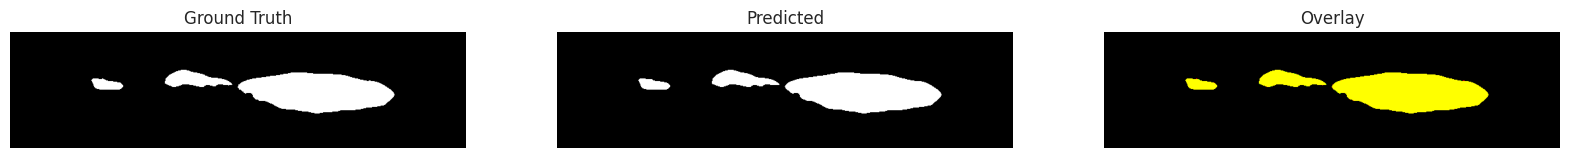

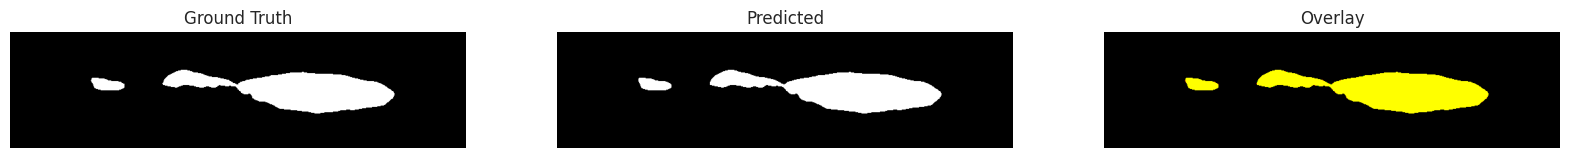

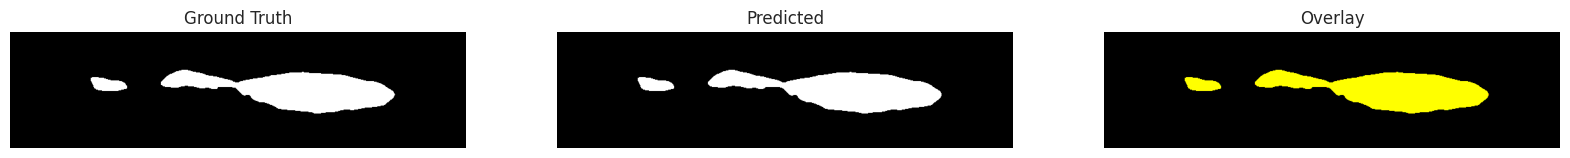

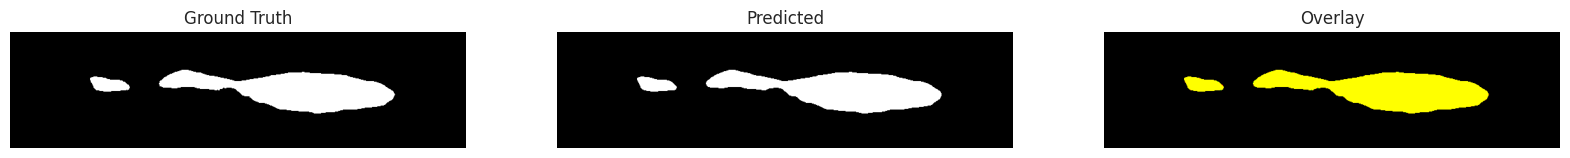

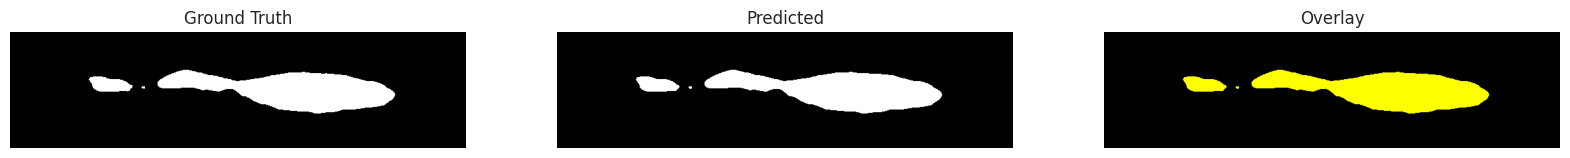

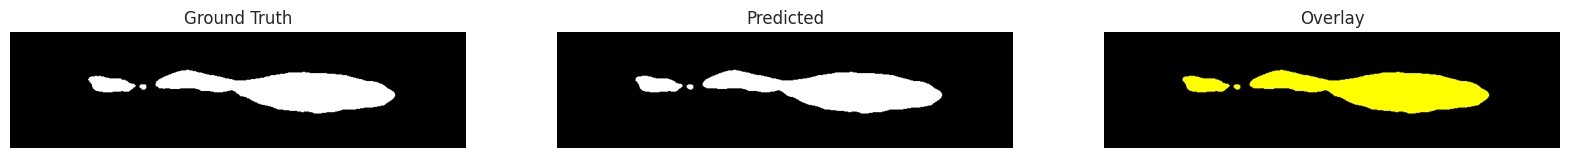

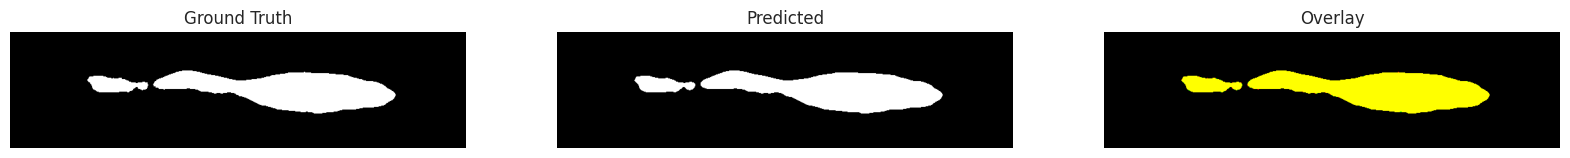

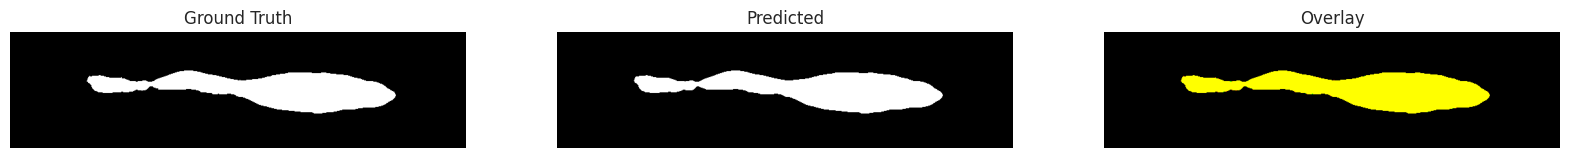

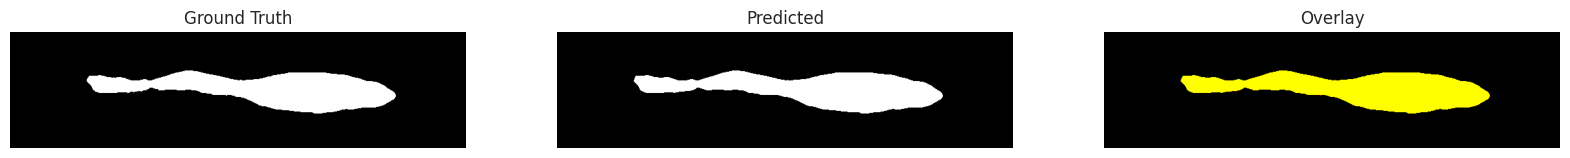

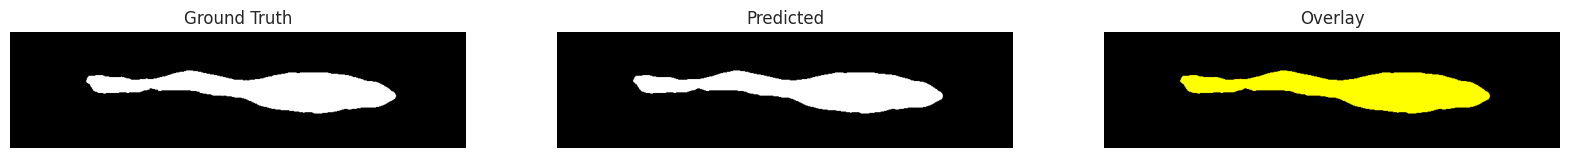

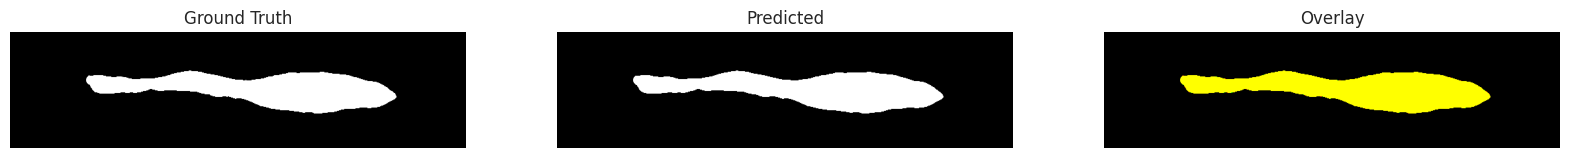

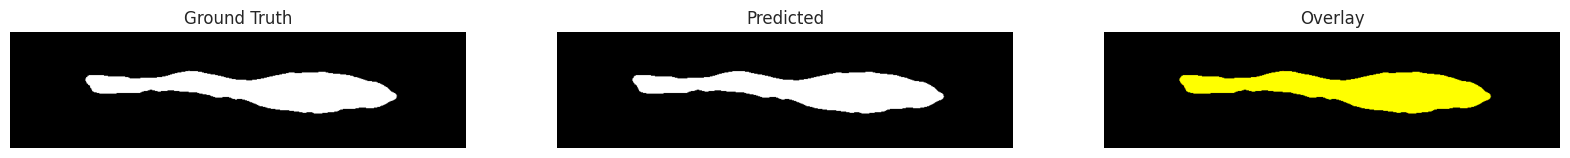

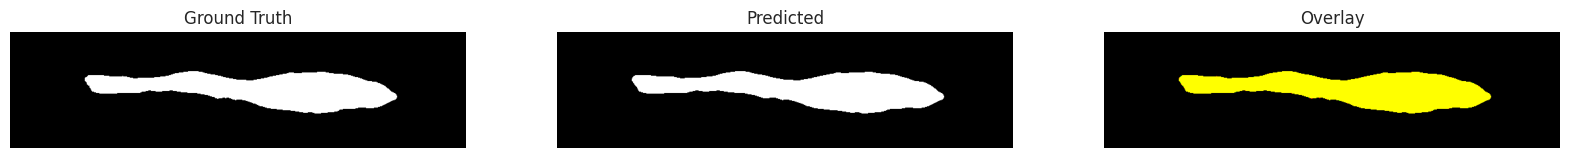

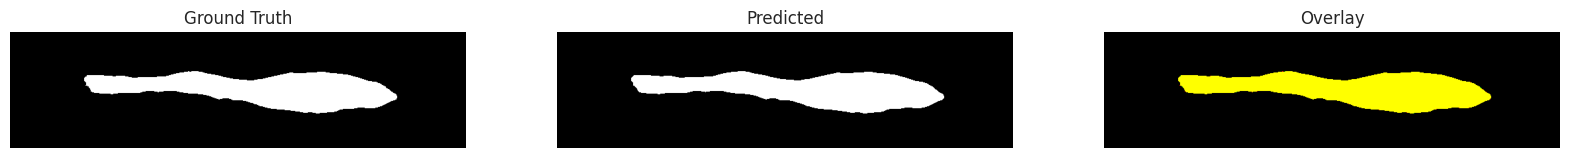

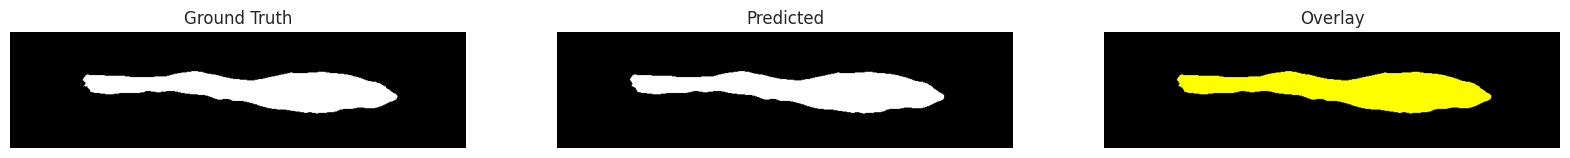

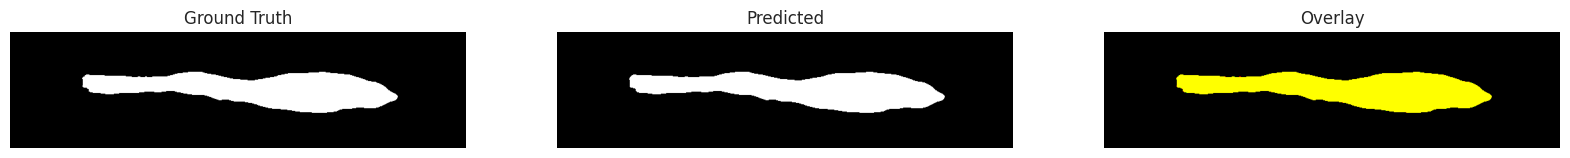

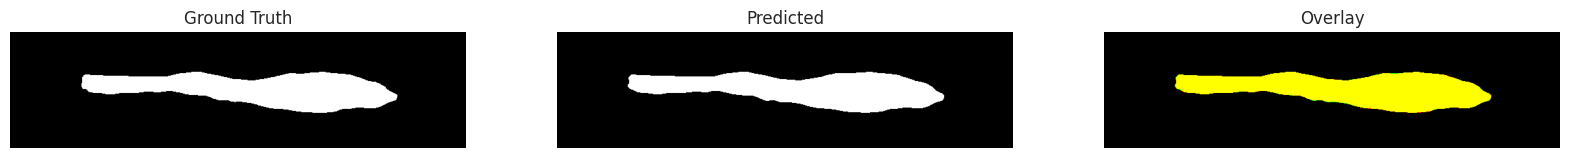

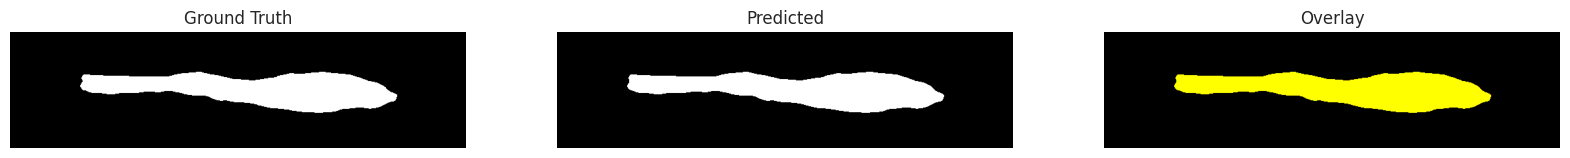

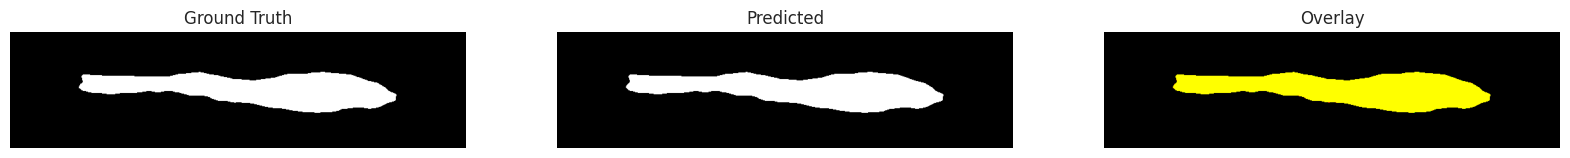

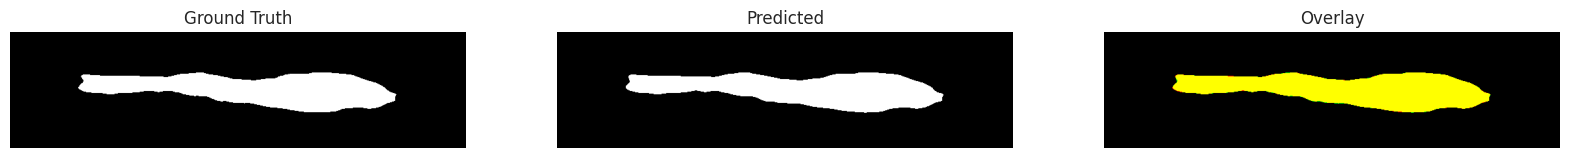

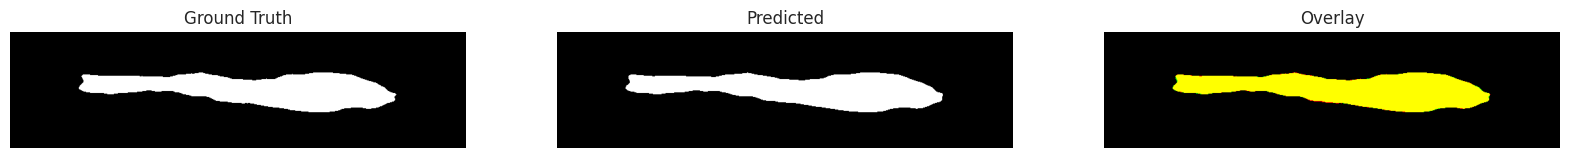

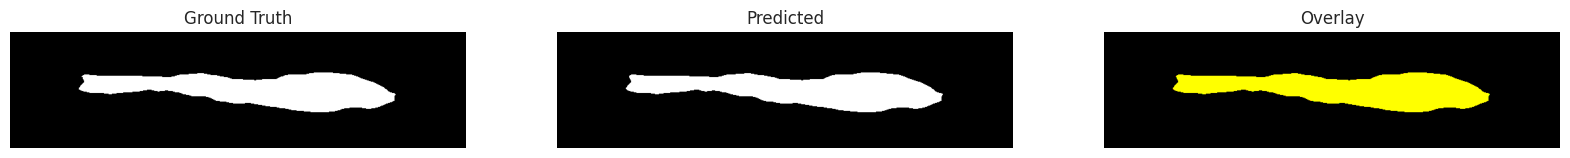

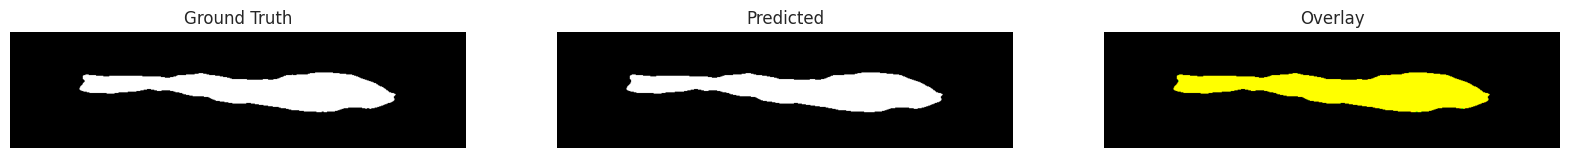

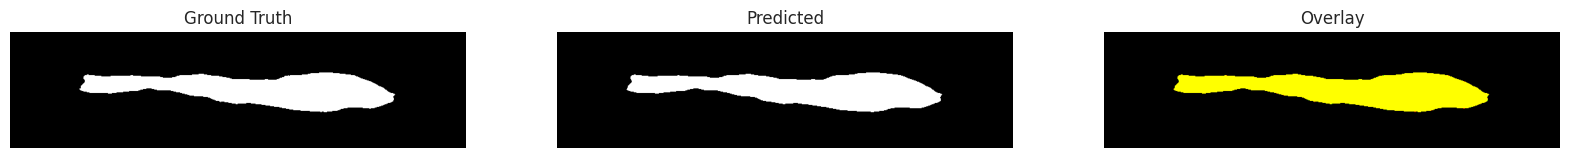

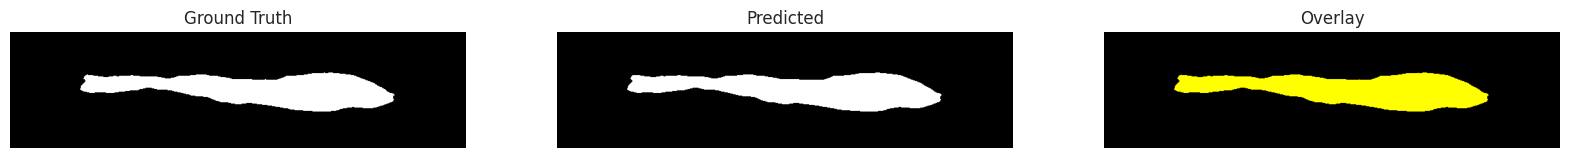

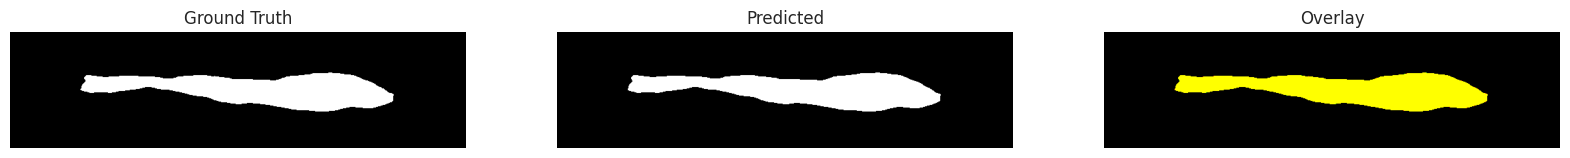

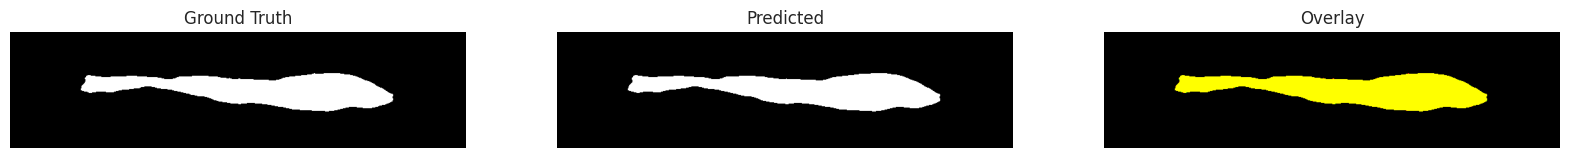

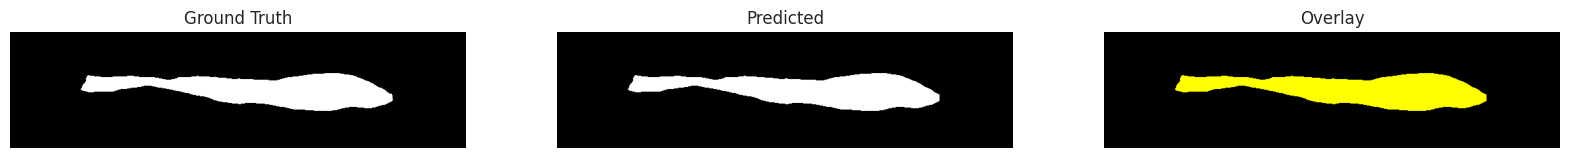

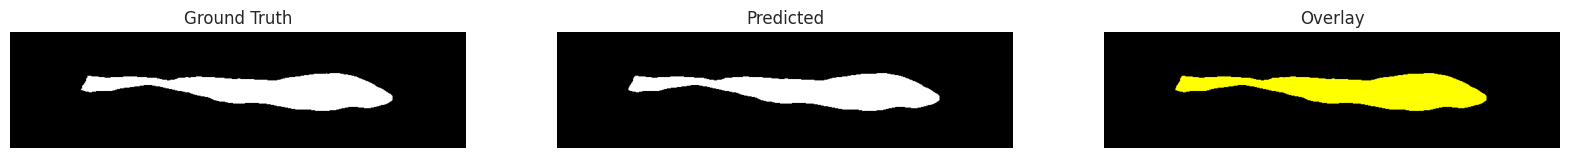

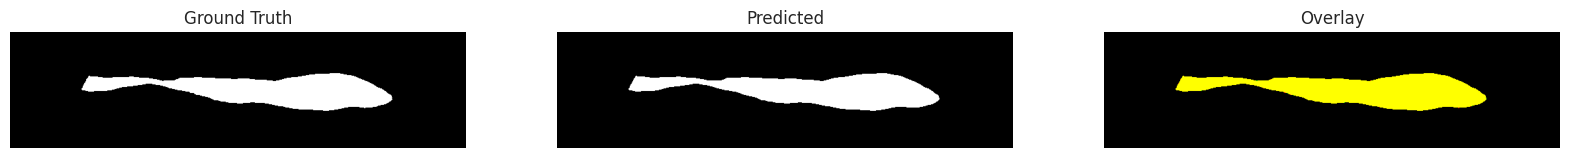

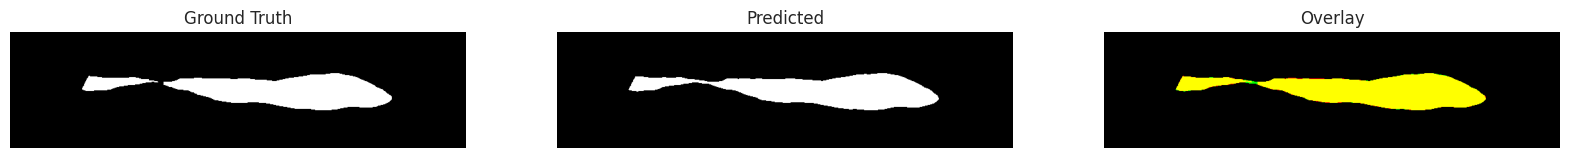

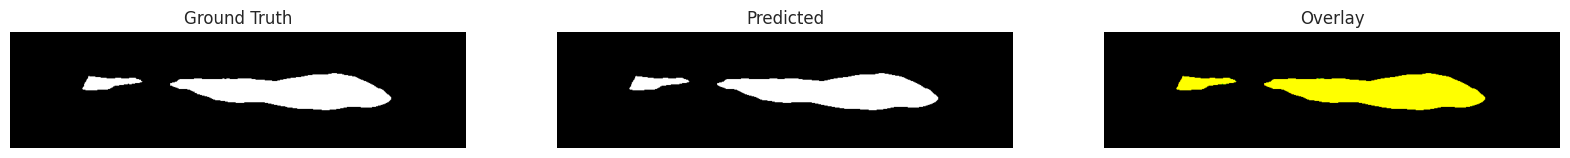

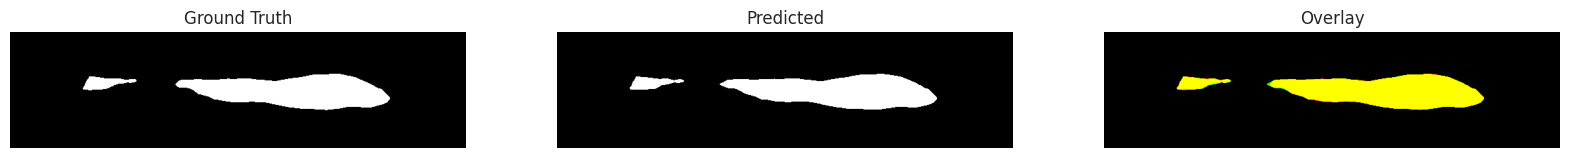

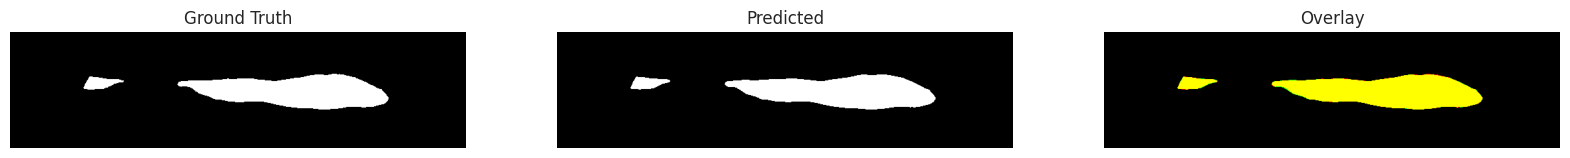

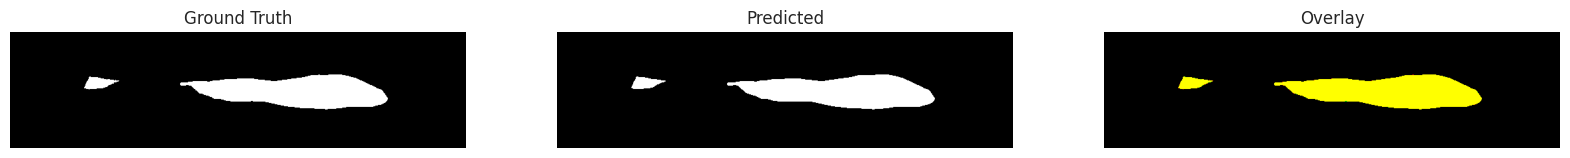

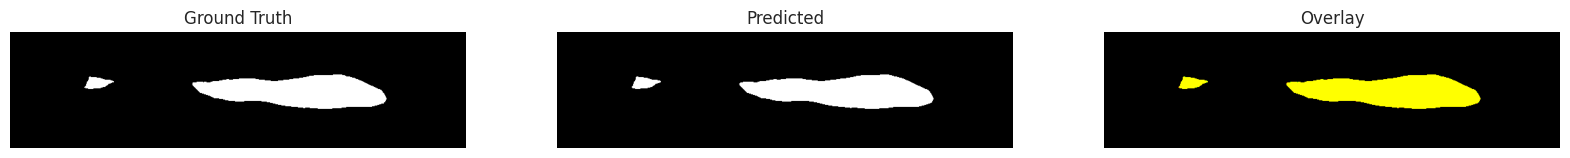

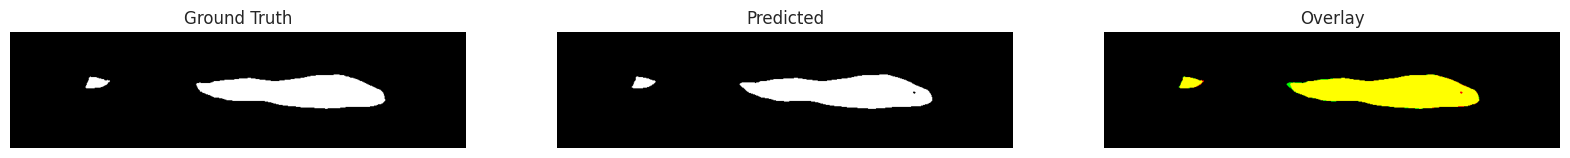

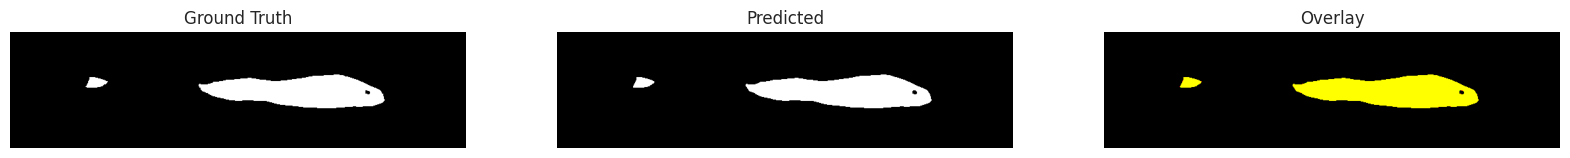

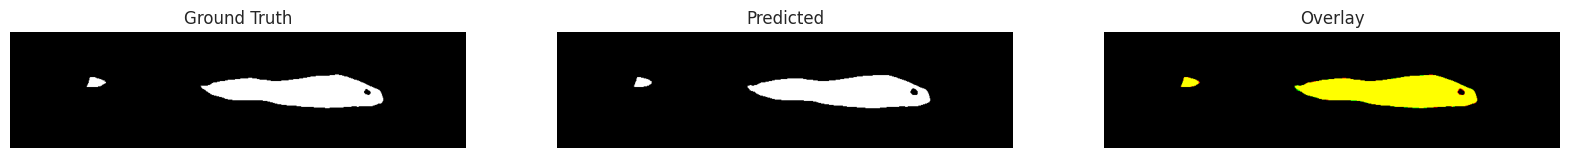

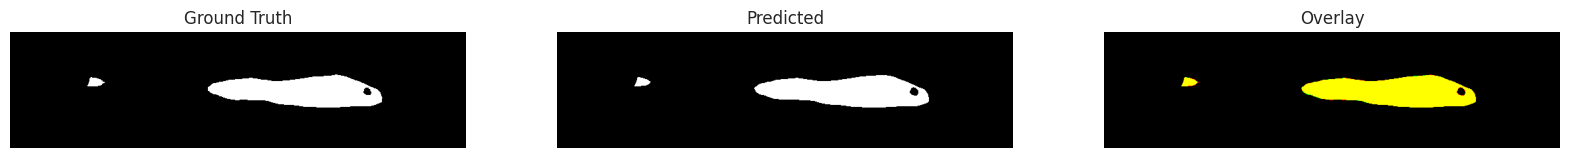

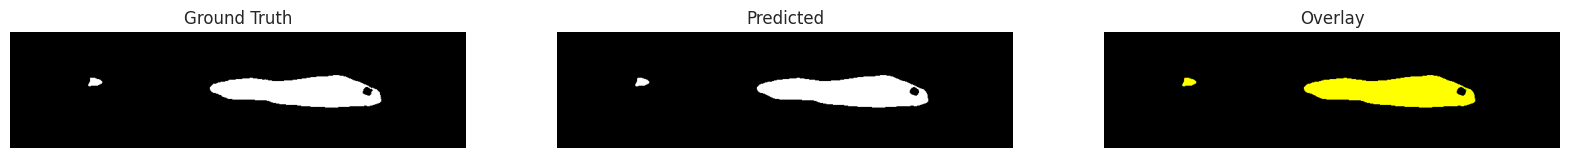

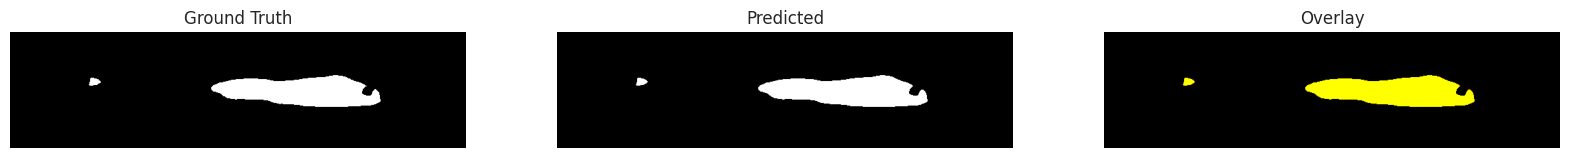

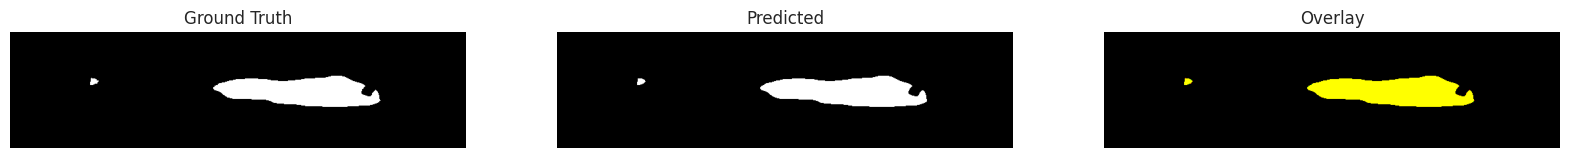

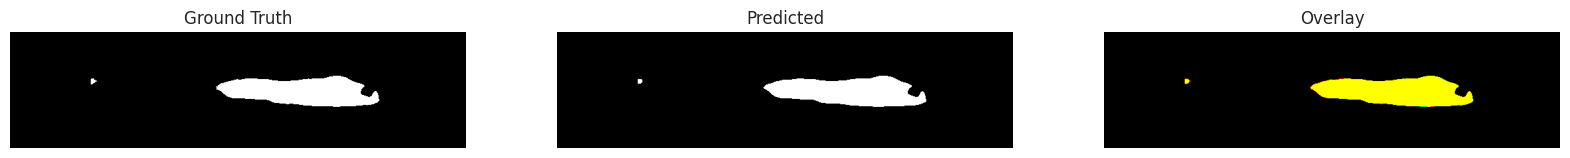

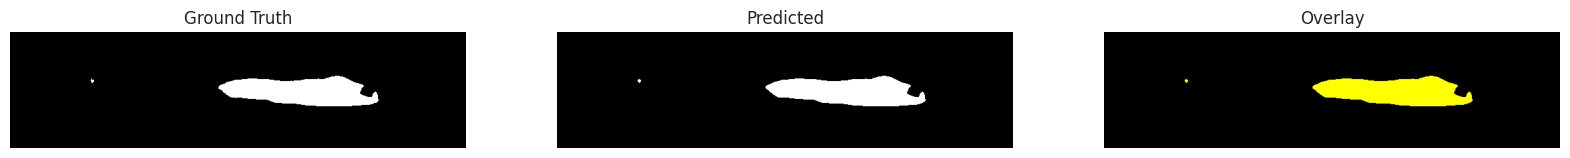

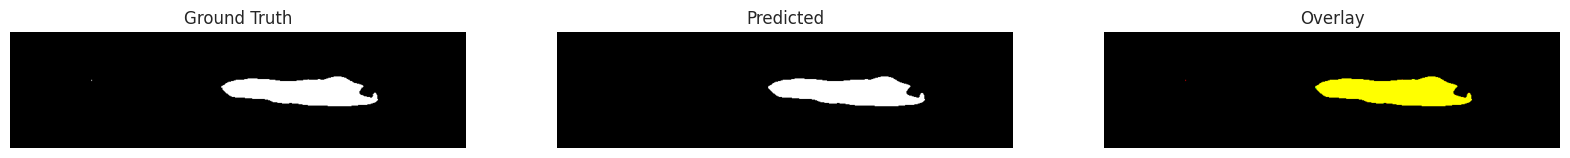

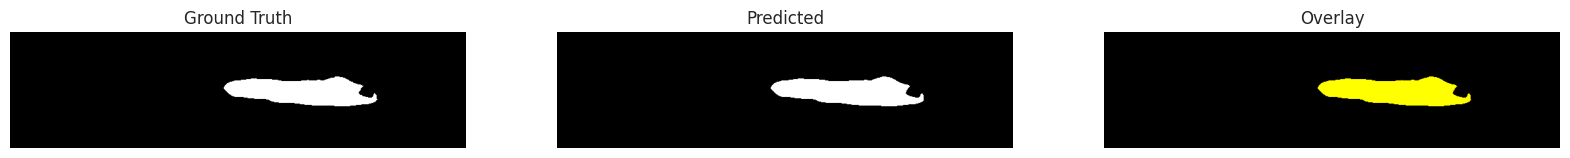

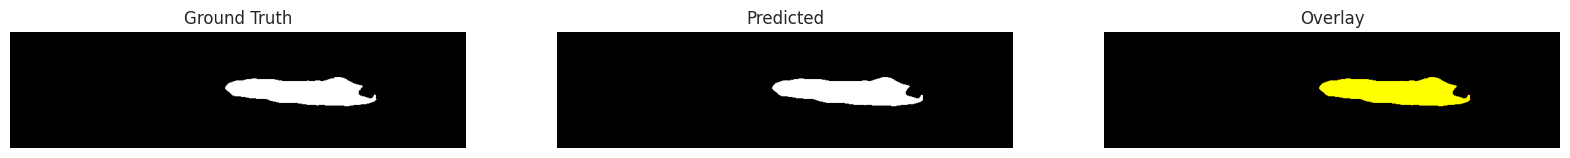

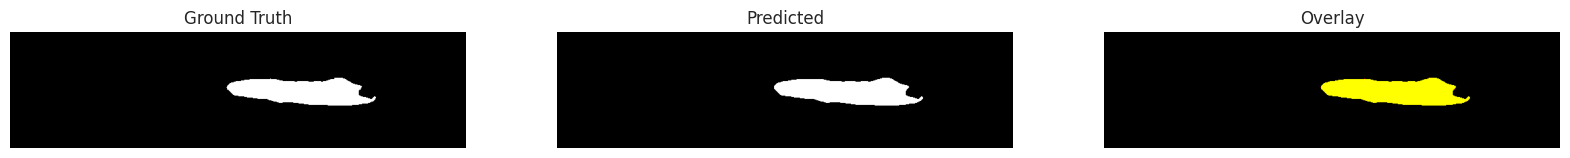

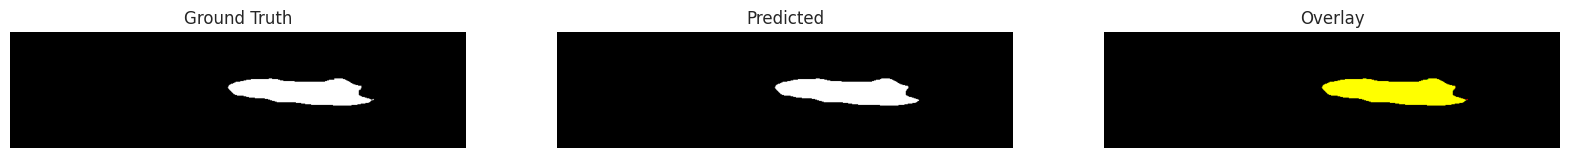

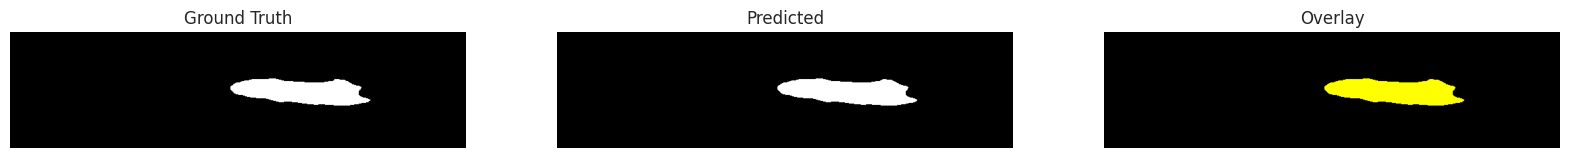

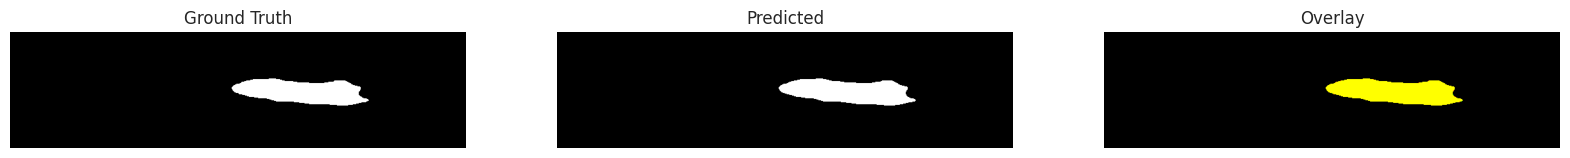

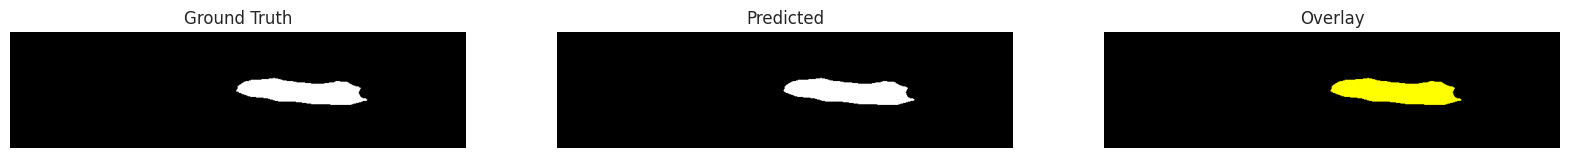

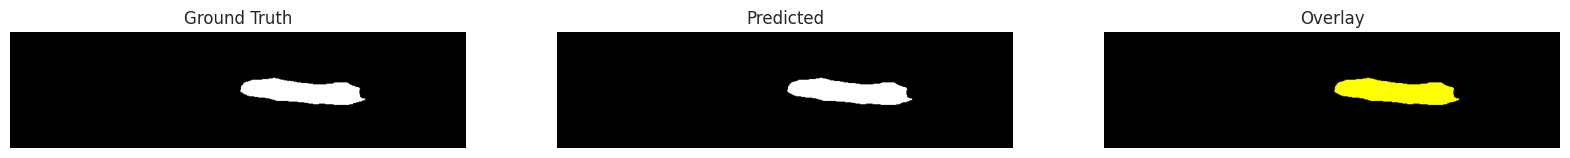

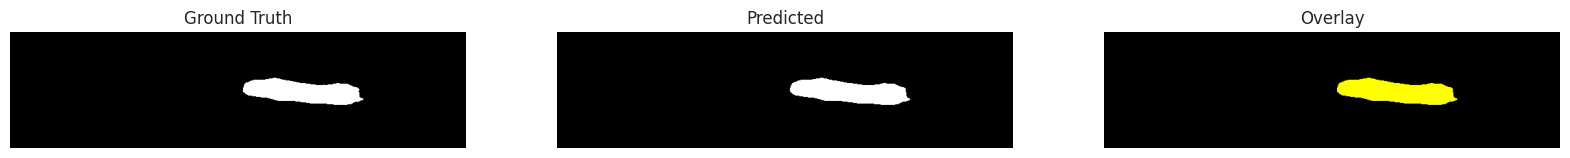

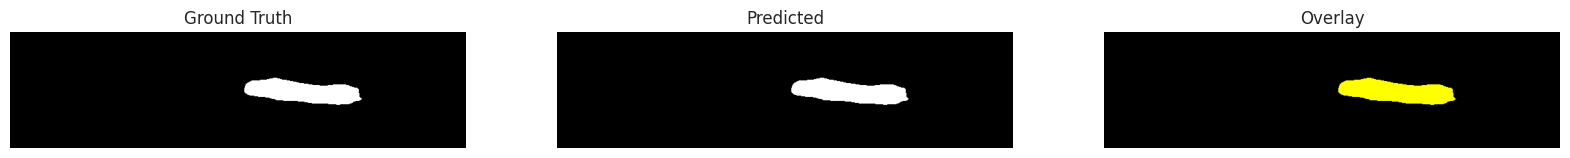

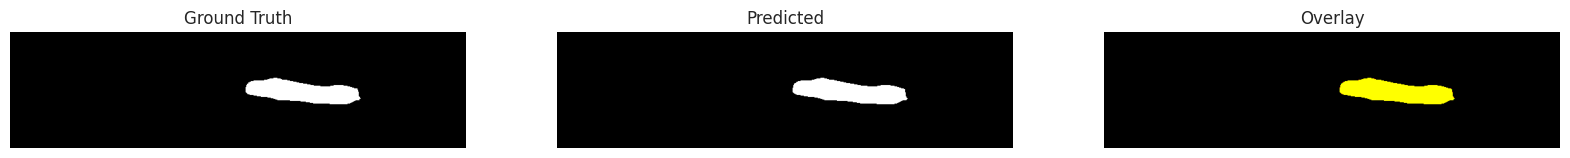

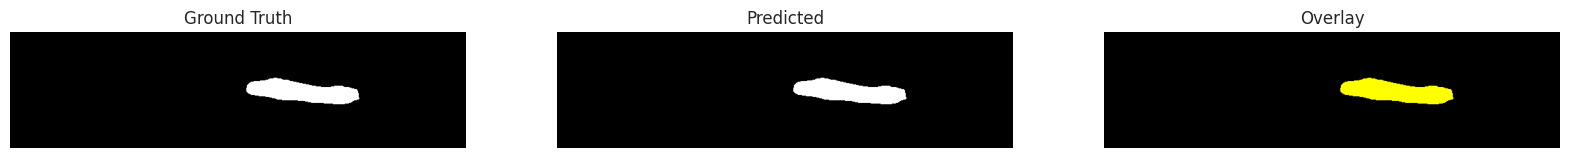

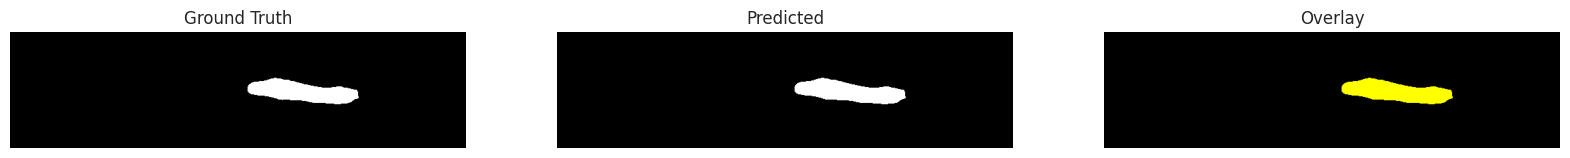

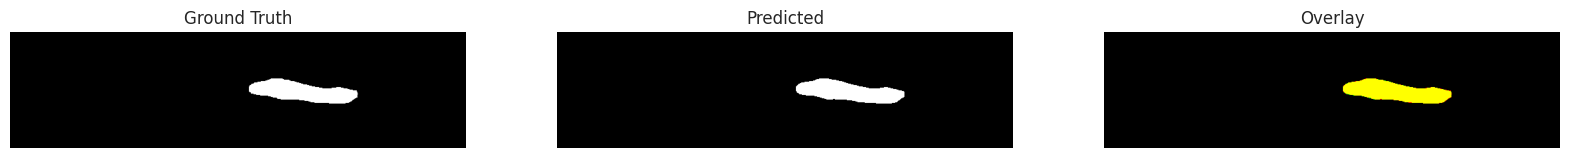

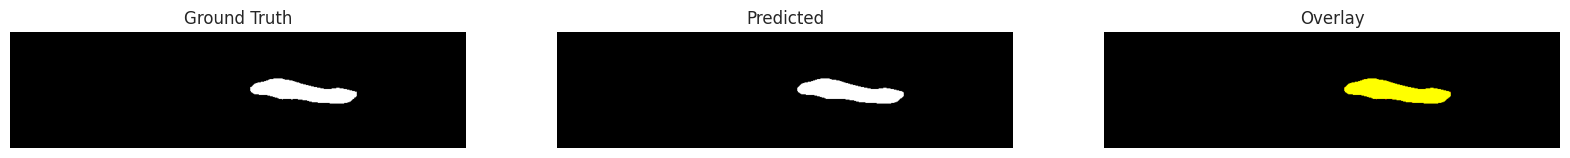

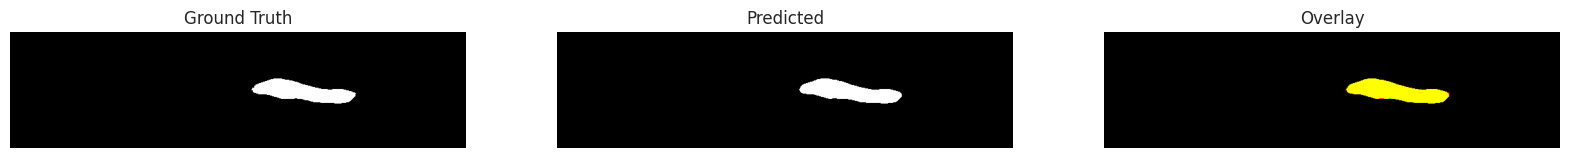

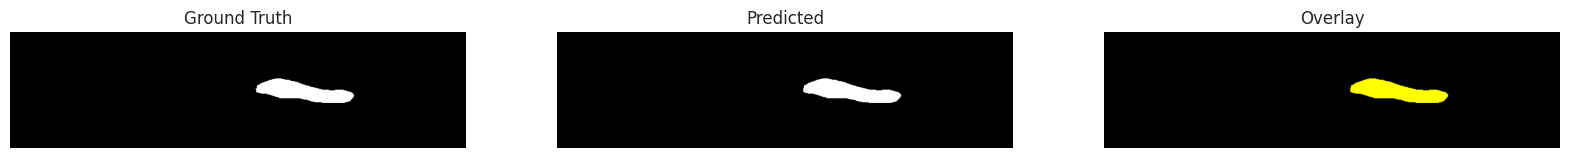

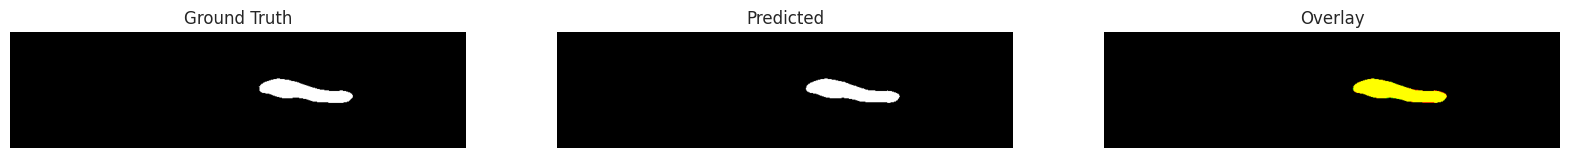

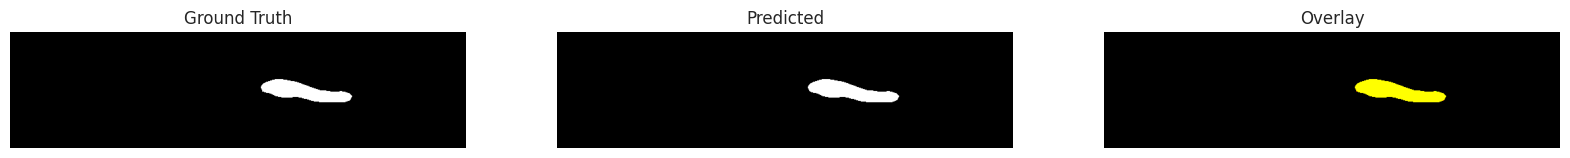

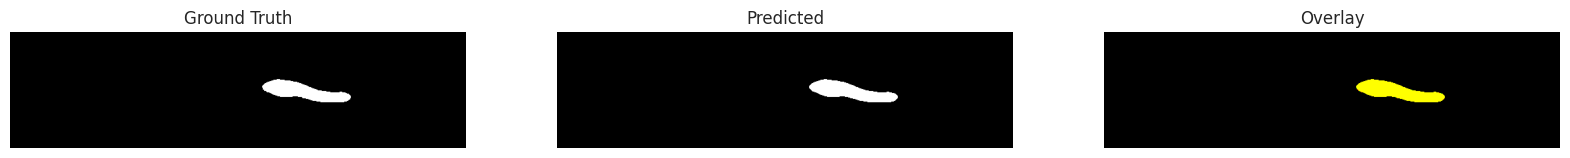

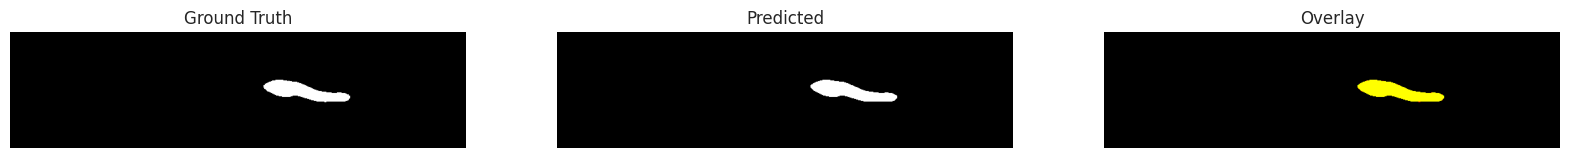

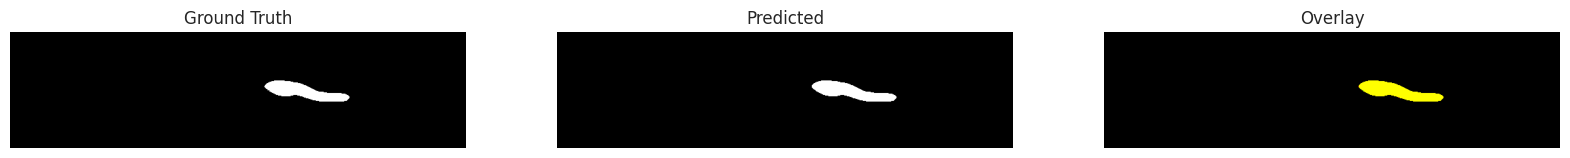

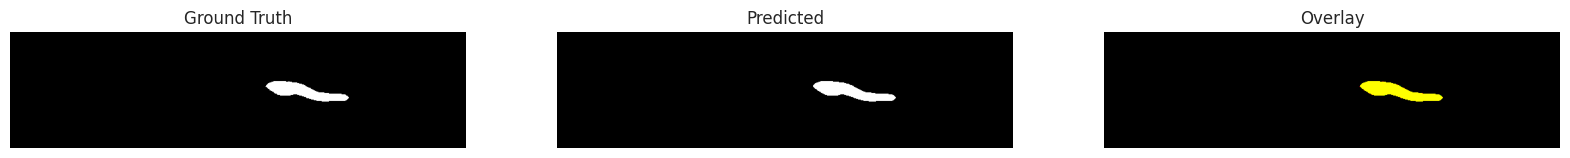

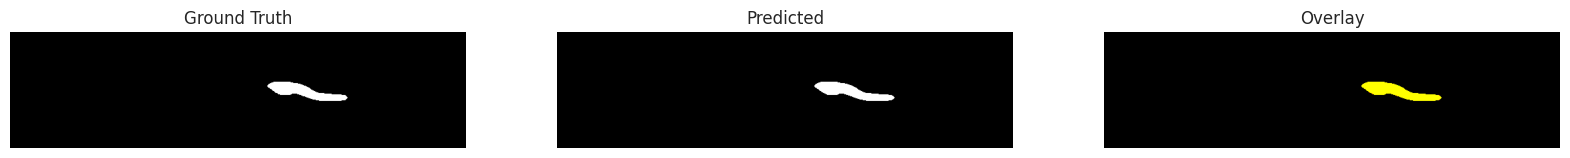

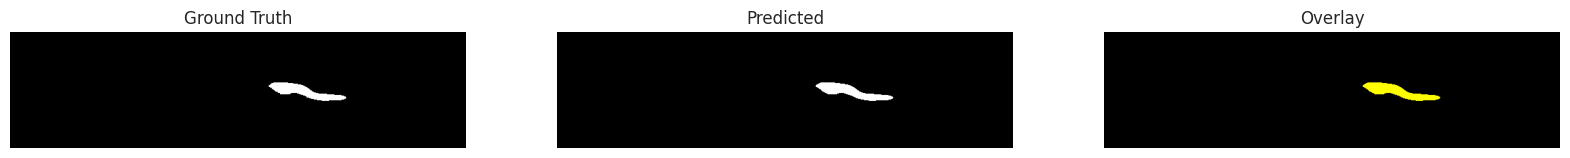

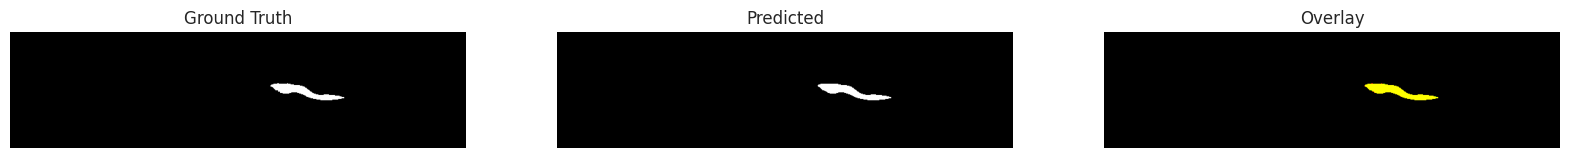

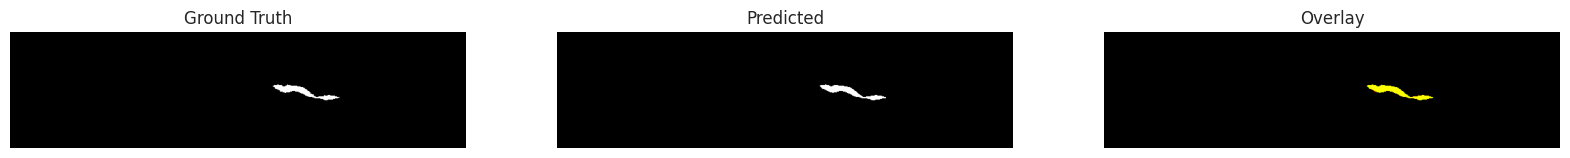

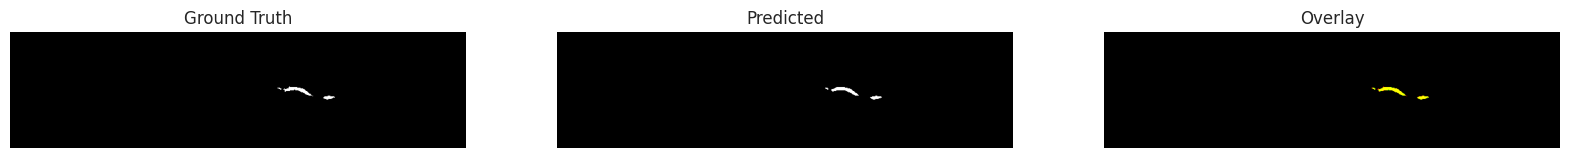

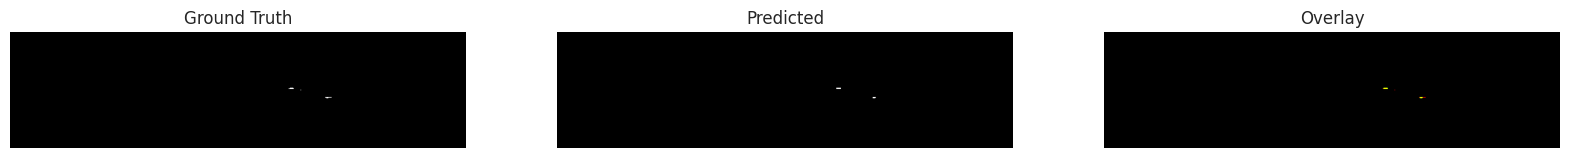

/tmp/ipykernel_423420/725589443.py:14: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
/tmp/ipykernel_423420/725589443.py:15: RuntimeWarning: invalid value encountered in cast
  return normalized_image.astype(np.uint8)


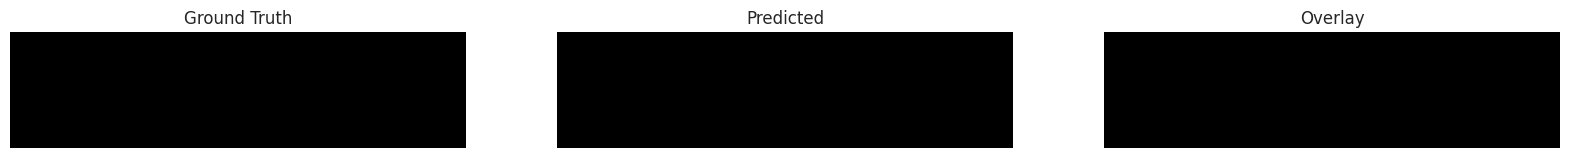

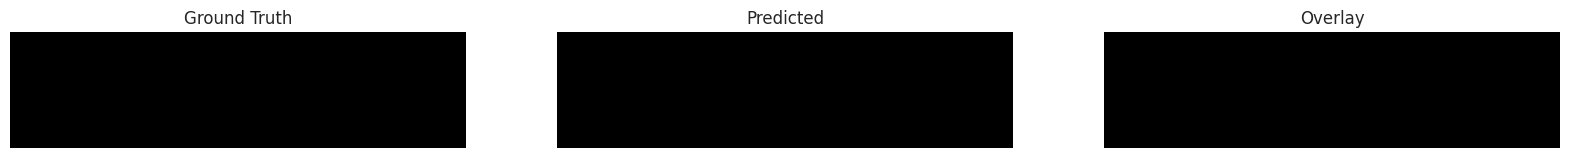

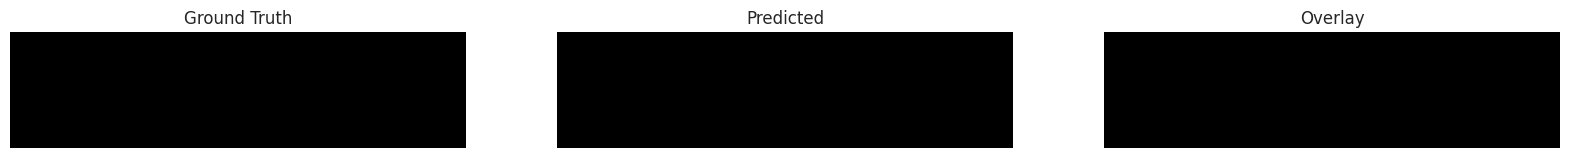

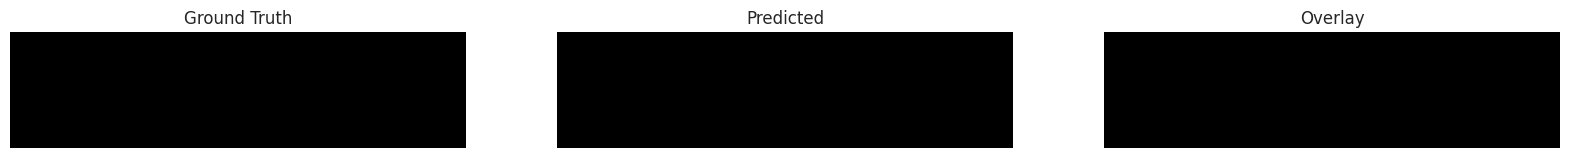

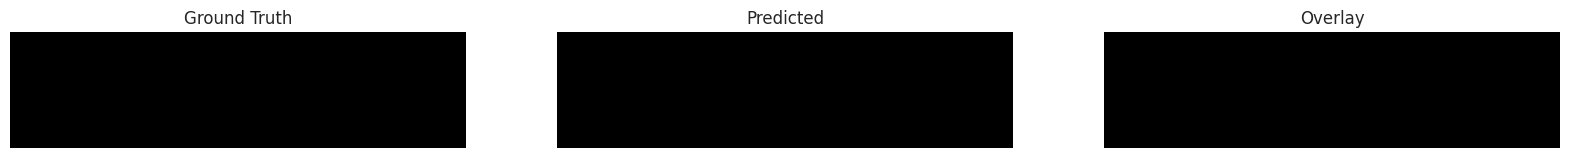

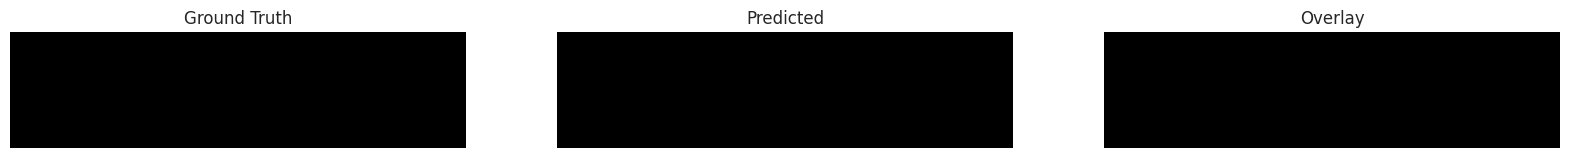

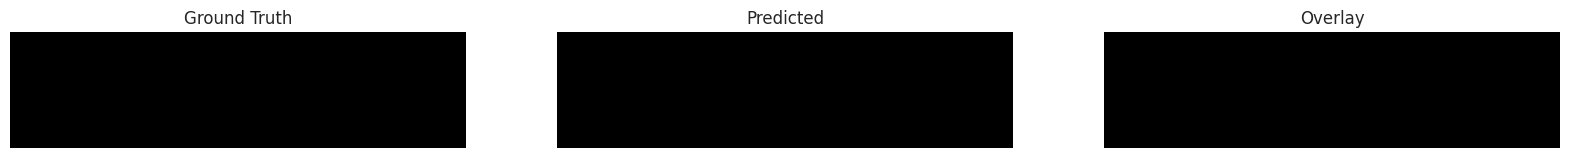

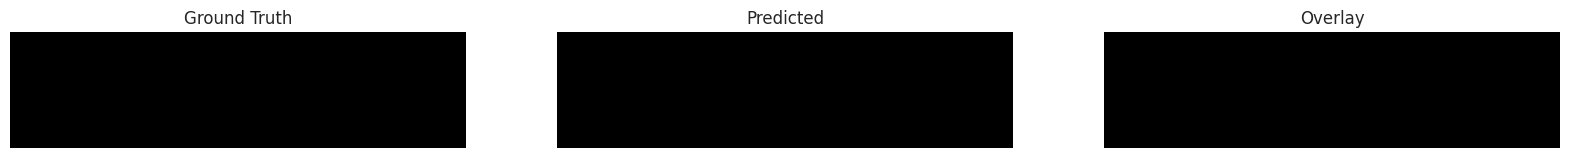

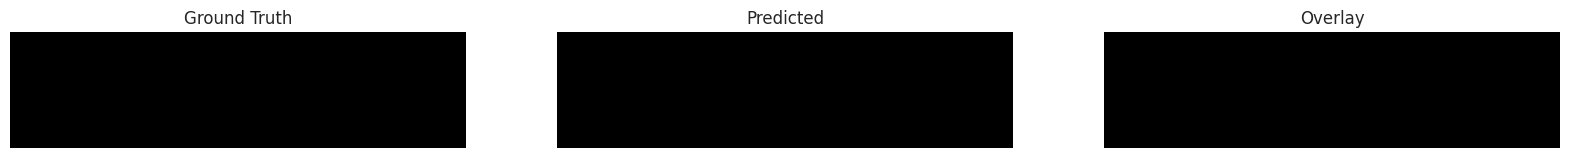

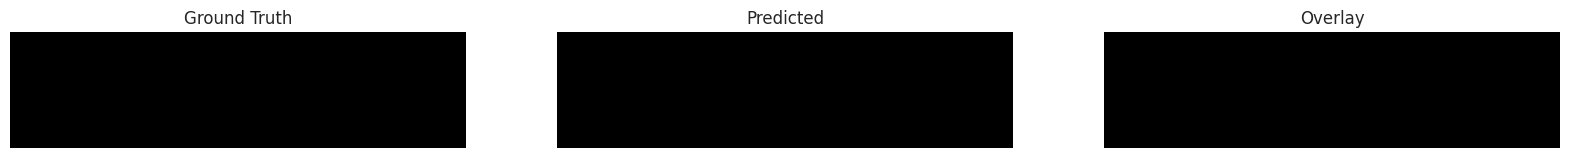

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load image using PIL and convert to numpy array."""
    image = Image.open(image_path)
    image_array = np.array(image)
    return image_array

def normalize_image(image):
    """Normalize the image to the range 0-255."""
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    return normalized_image.astype(np.uint8)

def overlay_images(image1, image2):
    """Overlay two images with different colors."""
    # Ensure images are of the same shape
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions.")
    
    # Normalize images to ensure proper contrast
    image1 = normalize_image(image1)
    image2 = normalize_image(image2)
    
    # Convert images to RGB if they are grayscale
    if len(image1.shape) == 2:
        image1 = np.stack((image1,) * 3, axis=-1)
    if len(image2.shape) == 2:
        image2 = np.stack((image2,) * 3, axis=-1)
    
    # Create a blank image with the same dimensions
    overlay = np.zeros_like(image1)
    
    # Assign red color to ground truth and green color to predictions
    overlay[:, :, 0] = image1[:, :, 0]  # Red channel
    overlay[:, :, 1] = image2[:, :, 1]  # Green channel
    
    return overlay

def display_overlay_images(folder1, folder2):
    """Display overlay images from two folders."""
    # Get list of TIF files in each folder
    tif_files1 = sorted([f for f in os.listdir(folder1) if f.lower().endswith('.tif')])
    tif_files2 = sorted([f for f in os.listdir(folder2) if f.lower().endswith('.tif')])
    
    # Check if number of TIFF files match
    if len(tif_files1) != len(tif_files2):
        raise ValueError("Number of TIFF files in the two folders do not match.")
    
    # Iterate through TIFF files and display overlay images
    for file1, file2 in zip(tif_files1, tif_files2):
        if file1 != file2:
            raise ValueError("Files in the two folders do not match.")
        
        # Construct full file paths for TIFF files
        image_path1 = os.path.join(folder1, file1)
        image_path2 = os.path.join(folder2, file2)
        
        # Load images
        image1 = load_image(image_path1)
        image2 = load_image(image_path2)
        
        # Overlay images
        overlay = overlay_images(image1, image2)
        
        # Display images
        plt.figure(figsize=(20, 20))  # Increase figure size
        plt.subplot(1, 3, 1)
        plt.imshow(image1, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(image2, cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title('Overlay')
        plt.axis('off')
        
        plt.show()

dataset_name = 'Dataset030_1030GlyRM1'
    
# Example usage:
gt_folder = r'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_raw/Dataset031_1030GlyRM1_noSplit/labelsTs/'
pred_folder = f'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_results/{dataset_name}/TrPlusTs_4_folds_250ep/'

display_overlay_images(gt_folder, pred_folder)


## The following three cells are supposed to be the same as the first code block but just seperated

In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def load_image(image_path):
    """Load image using PIL and convert to numpy array."""
    image = Image.open(image_path)
    image_array = np.array(image)
    return image_array

def calculate_similarity_metrics(image1, image2):
    """Calculate similarity metrics between two images."""
    # Convert images to numpy arrays if they are not already
    image1 = np.array(image1)
    image2 = np.array(image2)
    
    # Ensure images are of the same shape
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions.")
    
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(image1.flatten(), image2.flatten(), labels=[0, 1])
    tn, fp, fn, tp = confusion_mat.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(image1.flatten(), image2.flatten())
    precision = precision_score(image1.flatten(), image2.flatten())
    recall = recall_score(image1.flatten(), image2.flatten())
    f1 = f1_score(image1.flatten(), image2.flatten())
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    similarity_percentage = (tp + tn) / image1.size * 100  # Overall similarity percentage
    
    # Return metrics and confusion matrix values
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'similarity_percentage': similarity_percentage,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def compare_images_in_folders(folder1, folder2):
    """Compare images in two folders and calculate metrics."""
    # Get list of TIF files in each folder
    tif_files1 = sorted([f for f in os.listdir(folder1) if f.lower().endswith('.tif')])
    tif_files2 = sorted([f for f in os.listdir(folder2) if f.lower().endswith('.tif')])
    
    # Check if number of TIFF files match
    if len(tif_files1) != len(tif_files2):
        raise ValueError("Number of TIFF files in the two folders do not match.")
    
    results = []
    
    # Iterate through TIFF files and compare corresponding images
    for file1, file2 in zip(tif_files1, tif_files2):
        if file1 != file2:
            raise ValueError("Files in the two folders do not match.")
        
        # Construct full file paths for TIFF files
        image_path1 = os.path.join(folder1, file1)
        image_path2 = os.path.join(folder2, file2)
        
        # Load images
        image1 = load_image(image_path1)
        image2 = load_image(image_path2)
        
        # Calculate similarity metrics including confusion matrix
        metrics = calculate_similarity_metrics(image1, image2)
        metrics['file'] = file1
        metrics['image1_path'] = image_path1
        metrics['image2_path'] = image_path2
        
        # Add results to list
        results.append(metrics)
    
    return results

def save_metrics_to_csv(metrics_dict):
    """Save metrics dictionary to a CSV file."""
    df = pd.DataFrame(metrics_dict['metrics'])
    df['dataset'] = metrics_dict['dataset']
    df['epochs'] = metrics_dict['epochs']
    
    # Specify a custom directory if needed
    output_dir = '/argusdata/users/undergrads/ItamarAndDafna/metrics_2d/'  # Replace with your desired directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Construct the filename
    filename = f"metrics_{metrics_dict['dataset']}_{metrics_dict['epochs']}epochs.csv"
    file_path = os.path.join(output_dir, filename)
    df.to_csv(file_path, index=False)
    print(f"Metrics saved to {file_path}")


In [2]:
def display_results(results):
    """Display comparison results including metrics table, confusion matrices, and image comparison."""
    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    
    # Display metrics table
    print("Comparison Metrics:")
    print(df[['file', 'accuracy', 'precision', 'recall', 'f1_score', 'specificity', 'similarity_percentage']].to_string(index=False))
    print("\n")
    
    # Determine the grid size for the plots
    num_images = len(results)
    num_cols = 3  # Three columns: Ground Truth, Predicted, and Confusion Matrix
    num_rows = num_images
    
    # Create a figure for all subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    for idx, result in enumerate(results):
        file_name = result['file']
        tp, tn, fp, fn = result['tp'], result['tn'], result['fp'], result['fn']
        
        # Display ground truth image
        image1 = load_image(result['image1_path'])
        axes[idx, 0].imshow(image1, cmap='gray')
        axes[idx, 0].set_title(f'Ground Truth: {file_name}')
        axes[idx, 0].axis('off')
        
        # Display predicted image
        image2 = load_image(result['image2_path'])
        axes[idx, 1].imshow(image2, cmap='gray')
        axes[idx, 1].set_title(f'Predicted: {file_name}')
        axes[idx, 1].axis('off')
        
        # Plot confusion matrix
        sns.heatmap([[tn, fp], [fn, tp]], annot=True, cmap='Blues', fmt='g', ax=axes[idx, 2])
        axes[idx, 2].set_xlabel('Predicted labels')
        axes[idx, 2].set_ylabel('True labels')
        axes[idx, 2].set_title(f'Confusion Matrix for {file_name}')
    
    plt.tight_layout()
    plt.show()


In [3]:
def main():
    # Define the dataset name manually here
    dataset_name = 'Dataset030_1030GlyRM1'
    
    # Ask user for number of epochs
    num_epochs = input("Enter the number of epochs: ")
    
    gt_folder = r'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_raw/Dataset031_1030GlyRM1_noSplit/labelsTs/'
    results_folder = f'/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_results/{dataset_name}/{num_epochs}ep/'

    # Compare images in the specified folders
    results = compare_images_in_folders(gt_folder, results_folder)
    
    # Display results
    display_results(results)
    
    # Store metrics in a dictionary
    metrics_dict = {
        'dataset': dataset_name,
        'epochs': num_epochs,
        'metrics': results
    }
    
    # Save metrics to a CSV file
    save_metrics_to_csv(metrics_dict)
    
    return metrics_dict

# Run the main function
metrics_dict = main()

# Print the stored metrics dictionary
print(metrics_dict)


/home/gaon-izhar@bm.technion.ac.il/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaon-izhar@bm.technion.ac.il/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaon-izhar@bm.technion.ac.il/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

Comparison Metrics:
         file  accuracy  precision   recall  f1_score  specificity  similarity_percentage
image_001.tif  0.999876   0.998541 0.999027  0.998784     0.999921              99.987560
image_002.tif  0.997777   0.995258 0.963575  0.979160     0.999737              99.777732
image_003.tif  0.999693   0.997402 0.996945  0.997173     0.999851              99.969314
image_004.tif  0.999668   0.997339 0.996403  0.996871     0.999851              99.966826
image_005.tif  0.999768   0.998385 0.997096  0.997740     0.999913              99.976778
image_006.tif  0.999801   0.998178 0.997847  0.998012     0.999904              99.980095
image_007.tif  0.999759   0.998302 0.996780  0.997540     0.999913              99.975949
image_008.tif  0.999768   0.998273 0.996895  0.997583     0.999913              99.976778
image_009.tif  0.999834   0.998591 0.997888  0.998239     0.999930              99.983413
image_010.tif  0.999826   0.998736 0.997474  0.998105     0.999939              

Metrics saved to /argusdata/users/undergrads/ItamarAndDafna/metrics_2d/metrics_Dataset030_1030GlyRM1_TrPlusTs_4_folds_250epochs.csv
{'dataset': 'Dataset030_1030GlyRM1', 'epochs': 'TrPlusTs_4_folds_250', 'metrics': [{'accuracy': 0.9998755961020112, 'precision': 0.9985408560311284, 'recall': 0.9990267639902677, 'f1_score': 0.9987837509121869, 'specificity': 0.999921335547592, 'similarity_percentage': 99.98755961020112, 'tp': 6159, 'tn': 114401, 'fp': 9, 'fn': 6, 'file': 'image_001.tif', 'image1_path': '/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_raw/Dataset031_1030GlyRM1_noSplit/labelsTs/image_001.tif', 'image2_path': '/argusdata/users/undergrads/ItamarAndDafna/nnUNet/nnUNet_results/Dataset030_1030GlyRM1/TrPlusTs_4_folds_250ep/image_001.tif'}, {'accuracy': 0.9977773170226001, 'precision': 0.9952576667720519, 'recall': 0.9635751453933272, 'f1_score': 0.9791601866251944, 'specificity': 0.9997369367157426, 'similarity_percentage': 99.77773170226001, 'tp': 6296, 'tn': 114011, 'f